# Main results

### $\mathrm{IB}$ attack. Characterization of the phase transition

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from robustness import logger
logger.setLevel('INFO')

from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'meanS': 'o', 'Nsec': 's', 'varSgcc': '^'}
color_dict = {'meanS': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2'}
linestyle_dict = {'meanS': '--', 'Nsec': '-.', 'varSgcc': ':'}
measures_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$', 'varSgcc': r'$\chi$'}
line_colors = {'meanS': 'k', 'Nsec': 'grey', 'varSgcc': 'brown'}

1024
2048
4096
8192
16384
32768
65536
131072


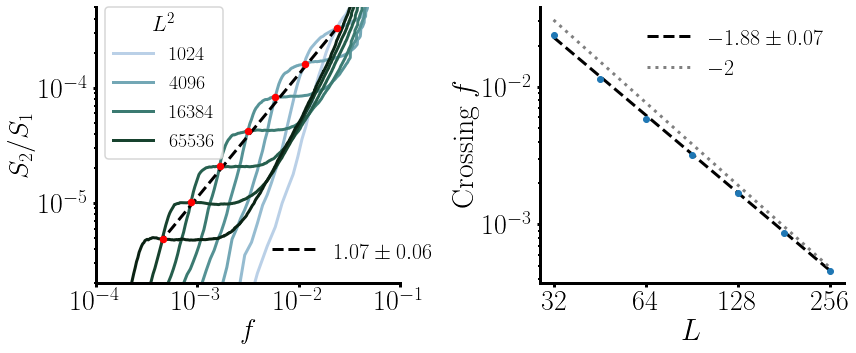

In [18]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        print(N)
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        df.f[1:], S2_over_S1[1:], '-',
        color=colors[i], label=label)
    if N != N_values[-1]:
        ax.scatter(*cross_values[i], color='red', zorder=100)

X, Y = cross_values[:,0], cross_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)
label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
        
#bbox = {'boxstyle': 'round', 'fc': 'None'}
#ax.text(0.04, 0.9, attack_dict[attack], fontsize=20, transform=ax.transAxes, bbox=bbox, 
#        horizontalalignment='left')


handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc=(0.03, 0.45))
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[-1:], labels[-1:],
          fontsize=22, loc=(0.55, 0.05), frameon=False)

ax = axes[1]

X = np.sqrt(sizes[:-1])
Y = cross_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)

label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)

label = r'$-2$'
ax.plot(X, powerlaw(X, -2, 2*c), ':', color='grey', label=label)
ax.plot(X, Y, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([32, 64, 128, 256])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\mathrm{Crossing}\; f$')
ax.legend(fontsize=22, frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'crossing_method_B_' + net_type)
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')

plt.show()

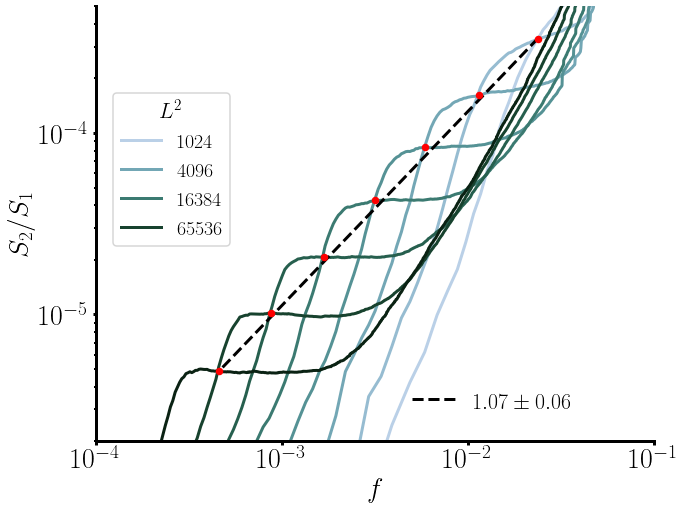

In [19]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        df.f[1:], S2_over_S1[1:], '-',
        color=colors[i], label=label)
    if N != N_values[-1]:
        ax.scatter(*cross_values[i], color='red', zorder=100)

X, Y = cross_values[:,0], cross_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)
label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc=(0.03, 0.45))
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[-1:], labels[-1:],
          fontsize=22, loc=(0.55, 0.05), frameon=False)

sns.despine()

plt.show()

0.019916080729166667 0.00039204663294173354


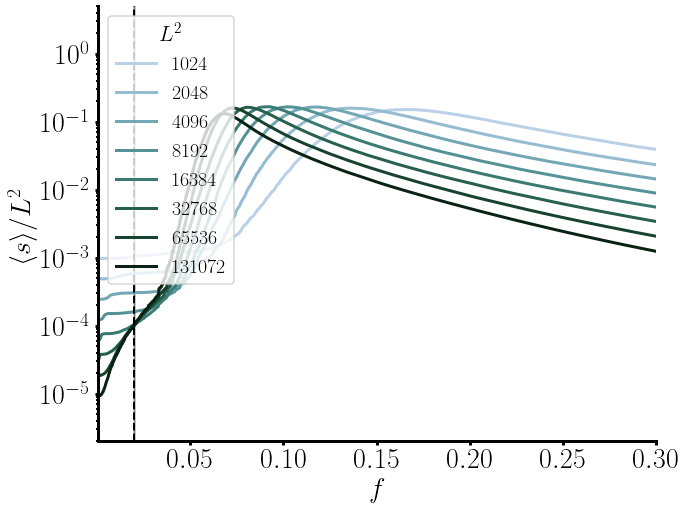

In [20]:
attack = 'Btw'
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

fmin = 1e-4
fmax = 0.3
ymin = 2e-6
ymax = 5e-0       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$\langle s \rangle / L^2$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    binder_cum = df.meanS / (N * df.Sgcc**2)
    binder_cum = df.meanS / N
    label = r'${{{}}}$'.format(N) #if i%2 == 0 else ''
    ax.plot(
        df.f[1:], 
        #S2_over_S1[1:], 
        binder_cum[1:],
        '-',
        color=colors[i], label=label)

_dfs = {k: v for k, v in dfs.items() if k > 9000}
mean_fc, std_fc = compute_fc_v2(_dfs, fmin, fmax, only_next=False, verbose=False, method='binder')
ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
print(mean_fc, std_fc)
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
sns.despine()

plt.show()

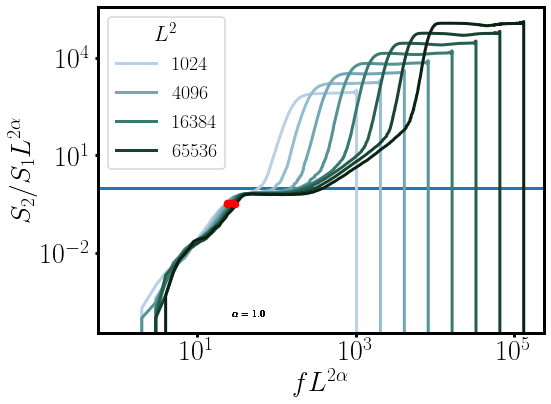

In [21]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)
   

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = ax
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(1)
#ax.set_xlim(5e-2, 10)
#ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1L^{2\alpha}$', fontsize=28)
ax.set_xlabel(r'$fL^{2\alpha}$', fontsize=28)

alpha = 1.
for i, N in enumerate(N_values):
    L = np.sqrt(N)
    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    label = r'${{{}}}$'.format(N) if i%2 == 0 else ''
    ax.plot(
        df.f[1:]*L**(2*alpha), S2_over_S1[1:]*L**(2*alpha), '-',
        color=colors[i], label=label
    )
    if N != N_values[-1]:
        x, y = cross_values[i]
        ax.scatter(x*L**(2*alpha), y*L**(2*alpha), color='red', zorder=100)
    text = r'$\alpha = {{{}}}$'.format(alpha)
    ax.text(0.3, 0.05, text, transform=ax.transAxes)
handles, labels = ax.get_legend_handles_labels()
## Markers
legend = ax.legend(fontsize=20, loc='best')
legend.set_title(r'$L^2$', prop={'size':22})

plt.show()

In [48]:
measures = ['meanS', 'Nsec', 'varSgcc']
attacks = ['Btw']

sizes = [
    #1024, 2048,
    4096, 8192, 16384, 32768, 65536#, 131072
]
print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values[-5:], measure_values[-5:])
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure in ['meanS', 'varSgcc']:
            gamma_over_nu = slope
            delta_gamma = y_err    
            
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Btw       	   0.0106   0.0141   2.0545   2.7393   2.0757   0.0855   2.0051    2.3324     65536


1024
2048
4096
8192
16384
32768
65536
131072
[0.1669921875, 0.1357421875, 0.117919921875, 0.1026611328125, 0.09088134765625, 0.080413818359375, 0.07177734375, 0.06775665283203125]
[0.171875, 0.14501953125, 0.122802734375, 0.1077880859375, 0.09326171875, 0.08306884765625, 0.0751190185546875, 0.0667724609375]


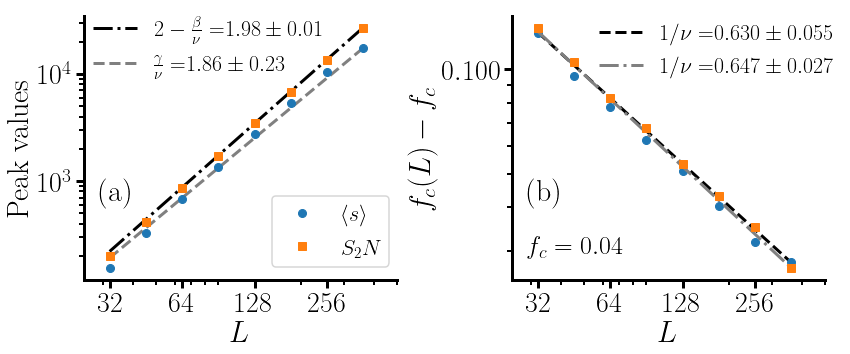

In [37]:
attack = 'Btw'
measures = [
    'meanS', 'Nsec', 
    #'varSgcc'
]

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.set_xlim(25, 500)
    ax.set_xticks([32, 64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
    c = measure_values[-1] / L_values[-1]**slope
    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        #line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)
        line1, = ax.plot(L_values, powerlaw(L_values, slope, c), '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, powerlaw(L_values, slope, c), '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3, 5][:len(measures)]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.04
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[-1] / X[-1]**slope
    label = r'$1/\nu = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
    #ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, powerlaw(X, slope, c), linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

1024
2048
4096
8192
16384
32768
65536
131072
[0.1494140625, 0.12353515625, 0.107177734375, 0.095458984375, 0.08502197265625, 0.076812744140625, 0.0685882568359375, 0.0625]


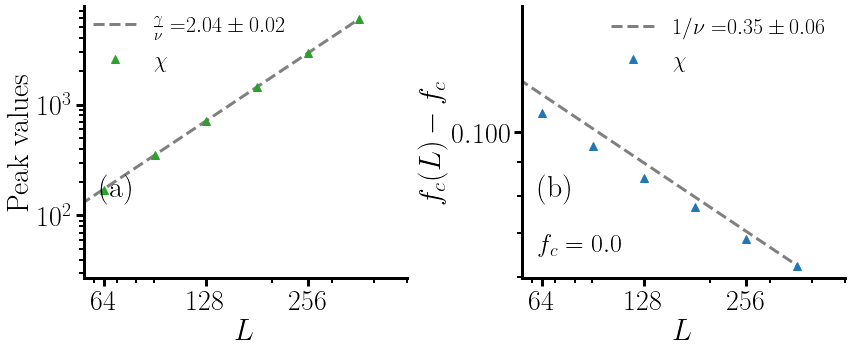

In [38]:
attack = 'Btw'
measures = ['varSgcc']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 500)
    ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
    c = Y_pred[-1] / L_values[-1]**slope
    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, powerlaw(X, slope, c), '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, powerlaw(X, slope, c), '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )
ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.0
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[-1] / X[-1]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, powerlaw(X, slope, c), '--', color='grey', label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
ax.legend(fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'chi_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [15]:
attack = 'Btw'

sizes = np.array([
    #256, 512, 
    1024, 2048, 4096, 
    8192, 16384, 32768, 65536, 131072,# 262144
])
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(net_type, N, param, attack, min_nseeds=10, return_nseeds=True)
    except FileNotFoundError:
        print(N)
        raise
        
    nseeds_values.append(nseeds)
    
    delta_data[:,2] = delta_data[:,2]*N
    mean_values = delta_data.mean(axis=0)
    std_values = delta_data.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_data - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

[  1024   2048   4096   8192  16384  32768  65536 131072] [0.14868398 0.12307358 0.10567444 0.09316479 0.08339266 0.07524434
 0.06786433 0.06101715] [0.28197881 0.29040273 0.29311506 0.29372362 0.29129794 0.2877203
 0.2850116  0.28085161]


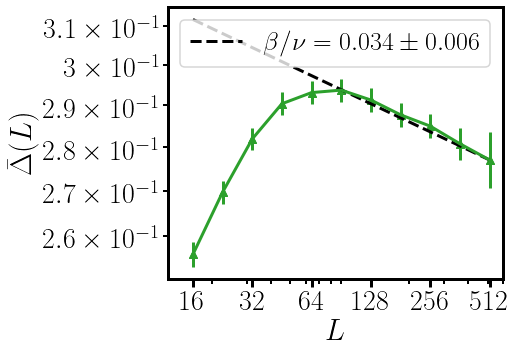

In [14]:
attack = 'Btw'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(12, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$\bar{\Delta}(L)$')
Y = delta_values
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8, fillstyle='none')
ax.errorbar(X, Y, Y_err, color='C2', markersize=8)

Y_pred, slope, y_err = getLinearReg(X[-6:], Y[-6:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$\beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend()
plt.show()

16384 100
32768 100
65536 100
131072 100
256 10000
512 10000
1024 10000
16384 10000
32768 10000
65536 10000
131072 10000


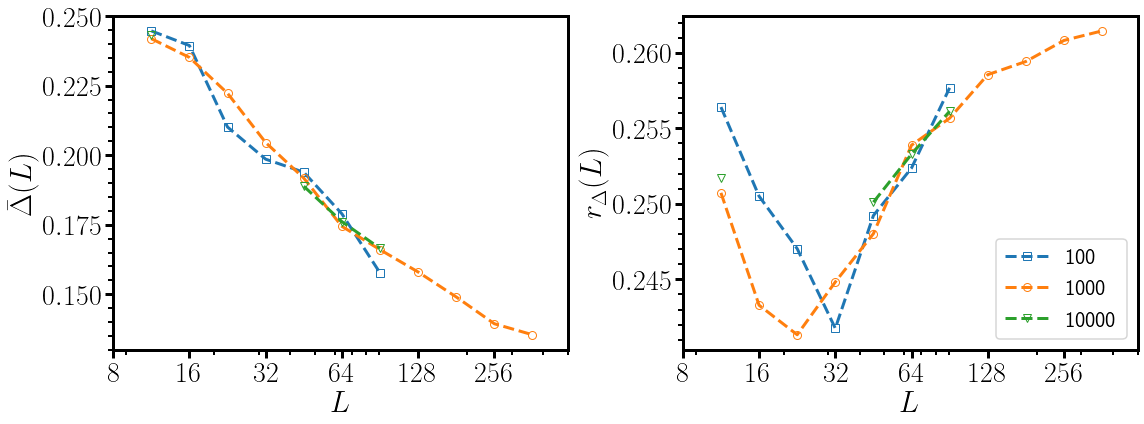

In [65]:
attack = 'Btw_cutoff4'
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlim(24, 500)
    ax.set_xticks([8, 16, 32, 64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
ax.set_ylabel(r'$\bar{\Delta}(L)$')
ax = axes[1]
ax.set_ylabel(r'$r_{\Delta}(L)$')
_sizes_parsed = []
for k, nseeds in enumerate([100, 1000, 10000]):
    sizes = np.array(
        [
            128, 256, 512, 1024, 2048, 
            4096, 8192, 16384, 32768, 65536,
            131072
        ]
    )
    all_mean_values = []
    all_std_values = []
    nseeds_values = []
    fluctuations = {}
    for i, N in enumerate(sizes):
        try:
            delta_data, nseeds = load_delta(
                net_type, N, param, attack, nseeds=nseeds, return_nseeds=True
            )
            #print(N, nseeds, delta_data.shape)
        except FileNotFoundError:
            print(N, nseeds)
            delta_data = np.empty((nseeds, 3))
            delta_data[:] = np.nan

        nseeds_values.append(nseeds)

        delta_data[:,2] = delta_data[:,2]*N
        mean_values = delta_data.mean(axis=0)
        std_values = delta_data.std(axis=0)

        all_mean_values.append(mean_values)
        all_std_values.append(std_values)

        fluctuations[N] = delta_data - mean_values

    all_mean_values = np.array(all_mean_values)
    all_std_values = np.array(all_std_values)

    rc_values = all_mean_values[:,0]
    delta_values = all_mean_values[:,1]

    X = np.sqrt(sizes)
    Y = delta_values
    ax = axes[0]
    ax.plot(
        X, Y, markers[k], linestyle='--', color=f'C{k}',
        markersize=8, fillstyle='none', label=nseeds
    )
    
    ax = axes[1]
    Y = rc_values
    ax.plot(
        X, Y, markers[k], linestyle='--', color=f'C{k}',
        markersize=8, fillstyle='none', label=nseeds
    )
    
ax.legend(fontsize=22)
plt.tight_layout()
plt.show()

2
3
4
6
16384 1000
8
10
256 1000
131072 1000
12
16384 1000
131072 1000
16


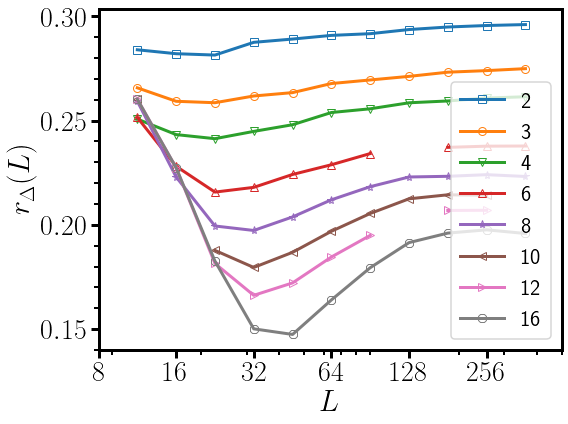

In [83]:
attack = 'Btw_cutoff4'
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)


ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(24, 500)
ax.set_xticks([8, 16, 32, 64, 128, 256])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L$')

ax.set_ylabel(r'$r_{\Delta}(L)$')

sizes = np.array(
    [
        128, 256, 512, 1024, 2048, 
        4096, 8192, 16384, 32768, 65536,
        131072
    ]
)
_l_values = [2, 3, 4, 6, 8, 10, 12, 16]
for k, l in enumerate(_l_values):
    print(l)
    attack = f'Btw_cutoff{l}'
    all_mean_values = []
    all_std_values = []
    nseeds_values = []
    fluctuations = {}
    for i, N in enumerate(sizes):
        #ax.axvline(l_cutoff[N], linestyle='-', color=f'C{i}')
        try:
            delta_data, nseeds = load_delta(
                net_type, N, param, attack, nseeds=1000, return_nseeds=True
            )
            #print(N, nseeds, delta_data.shape)
        except FileNotFoundError:
            print(N, nseeds)
            delta_data = np.empty((nseeds, 3))
            delta_data[:] = np.nan

        nseeds_values.append(nseeds)

        delta_data[:,2] = delta_data[:,2]*N
        mean_values = delta_data.mean(axis=0)
        std_values = delta_data.std(axis=0)

        all_mean_values.append(mean_values)
        all_std_values.append(std_values)

        fluctuations[N] = delta_data - mean_values

    all_mean_values = np.array(all_mean_values)
    all_std_values = np.array(all_std_values)

    rc_values = all_mean_values[:,0]
    delta_values = all_mean_values[:,1]

    Y = rc_values
    ax.plot(
        X, Y, markers[k], linestyle='-', color=f'C{k}',
        markersize=8, fillstyle='none', label=l
    )
    

ax.legend(fontsize=22)
plt.tight_layout()
plt.show()

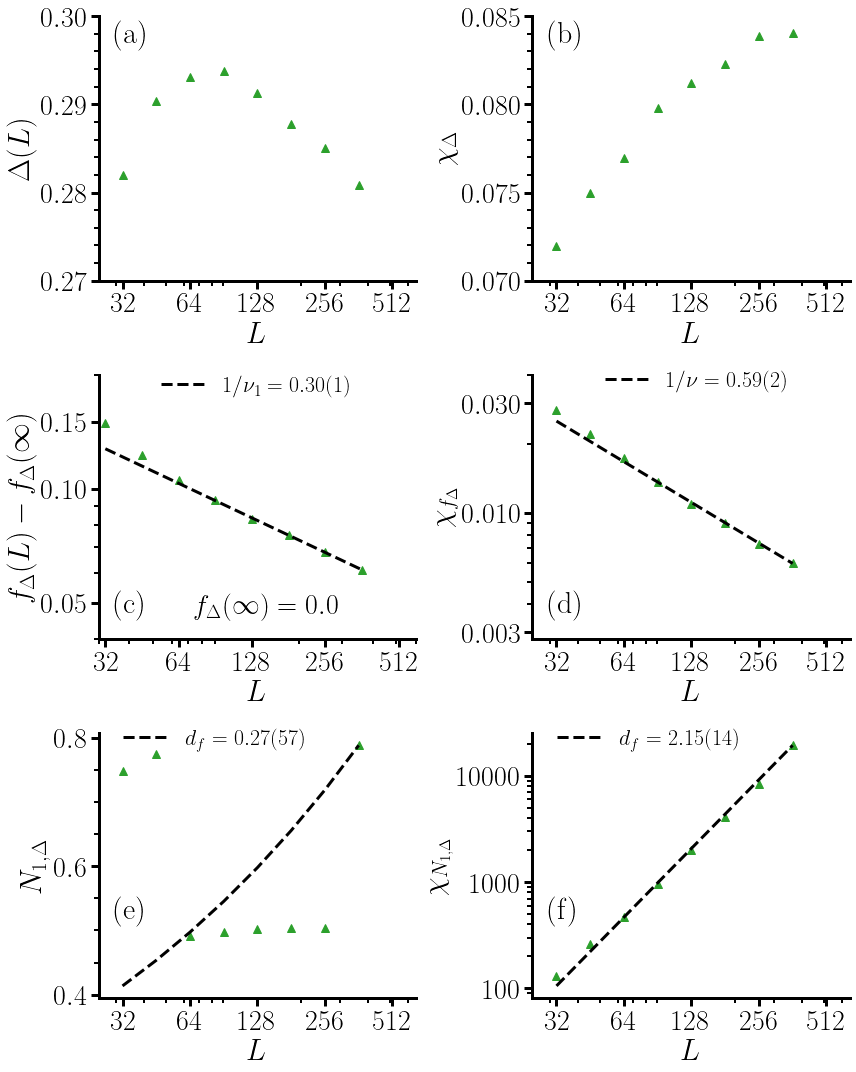

In [16]:
attack = 'Btw'

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(25, 650)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
ax.set_ylim(0.27, 0.30)
ax.text(0.05, 0.9, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta (L)$')
X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)

###################################################################

ax = axes[1,0]
ax.set_yscale('log')
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
ax.set_ylim(0.04, 0.2)
ax.set_yticks([0.05, 0.1, 0.15])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$f_{\Delta}(L) - f_{\Delta}(\infty)$')
rc = 0.0
X = np.sqrt(sizes)
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = r'$1/\nu_1={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
ax.set_xlim(30, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.3, 0.1, r'$f_{\Delta}$' + r'$(\infty)={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
sns.despine()

#############################################################


ax = axes[0,1]
ax.set_ylim(0.07, 0.085)
ax.text(0.05, 0.9, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
#ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

###############################################################

ax = axes[1,1]
ax.set_yscale('log')
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.0028, 0.04])
ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{f_{\Delta}}$')
Y = all_std_values[:,0]

Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$1/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = label=r'$1/\nu={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.2, 0.9), frameon=False)

######################################################################

ax = axes[2,0]
#ax.set_yscale('log')
ax.text(0.05, 0.3, letters[4], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$N_{1,{\Delta}}$')
Y = all_mean_values[:,2] / sizes
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f={{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
label = label=r'$d_f={{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

###############################################################

ax = axes[2,1]
ax.set_yscale('log')
ax.text(0.05, 0.3, letters[5], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{N_{1,\Delta}}$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f = {{{:.2f}}}\pm {{{:.0f}}}$'.format(slope, y_err)
label = label=r'$d_f = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

################################################################

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

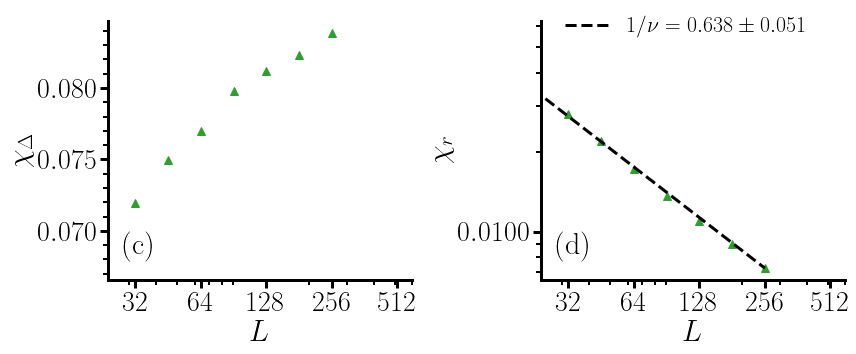

In [13]:
attack = 'Btw'
X = np.sqrt(sizes)

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_xlim(24, 600)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')

ax = axes[0]
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax = axes[1]
ax.set_yscale('log')
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.02])
#ax.set_yticks([0.002, 0.01, 0.02])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]

Y_pred, slope, y_err = getLinearReg(X[-6:], Y[-6:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$1/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

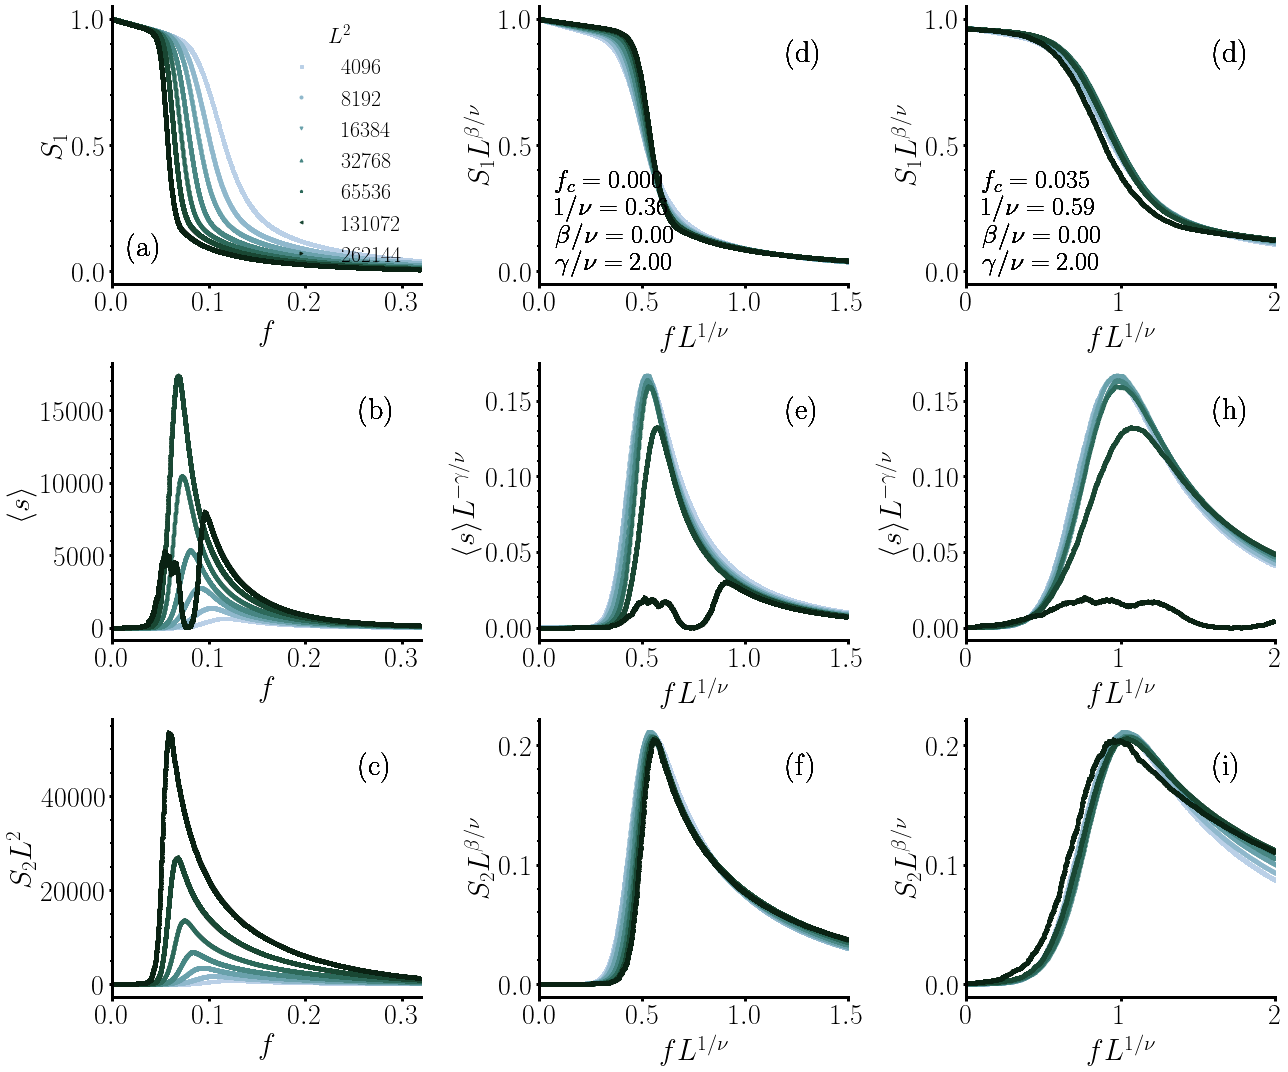

In [12]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536, 131072, 262144]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.32)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.36
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.59
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.035
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[1+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[2+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

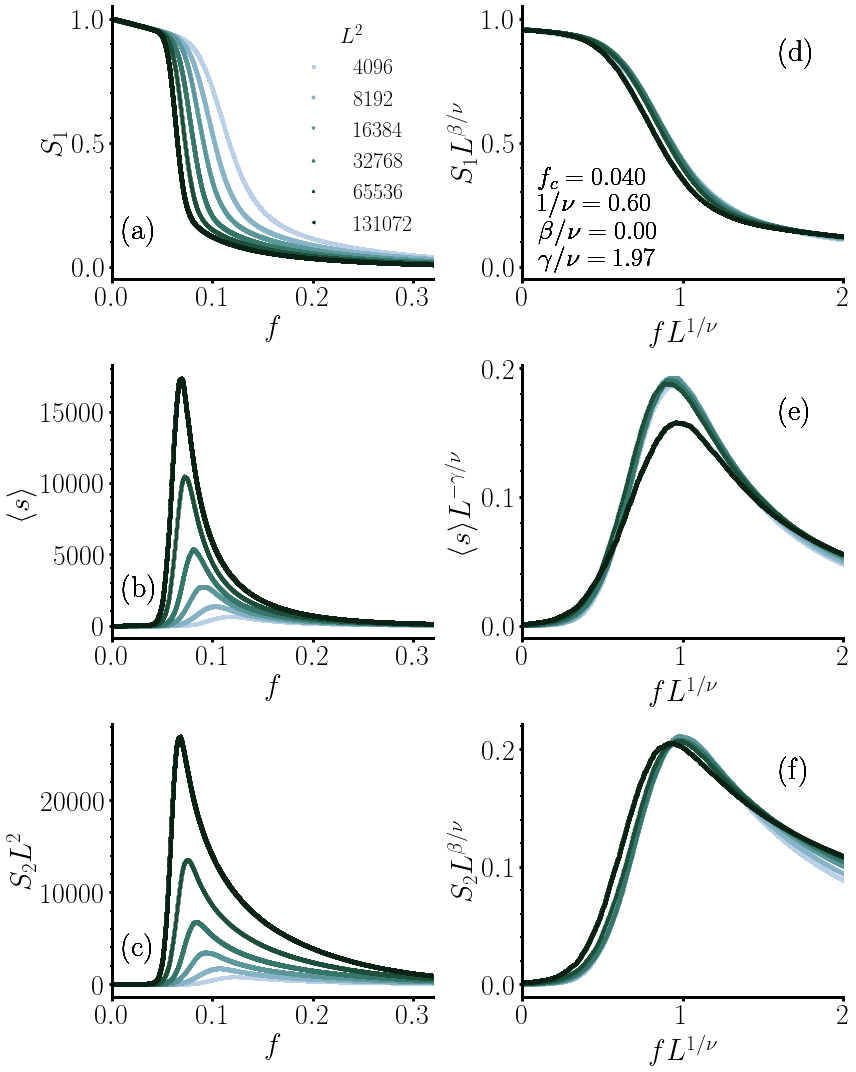

In [40]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536, 131072]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.32)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')

ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.03, 0.15, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.03, 0.15, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.03, 0.15, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
if False:
    one_over_nu = 0.4
    gamma_over_nu = 2
    beta_over_nu = 0
    fc = 0.0
else:
    one_over_nu = 0.6
    gamma_over_nu = 1.97
    beta_over_nu = 0
    fc = 0.04
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,1]
    ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

    ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    ax.text(
        0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
        transform=ax.transAxes, fontsize=26
    )

    ax = axes[1,1]
    ax.text(0.8, 0.8, letters[1+3], transform=ax.transAxes, fontsize=30)
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )  

    ax = axes[2,1]
    ax.text(0.8, 0.8, letters[2+3], transform=ax.transAxes, fontsize=30)
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_twoCols_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

<ipython-input-78-eff17e7d8d4f>:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


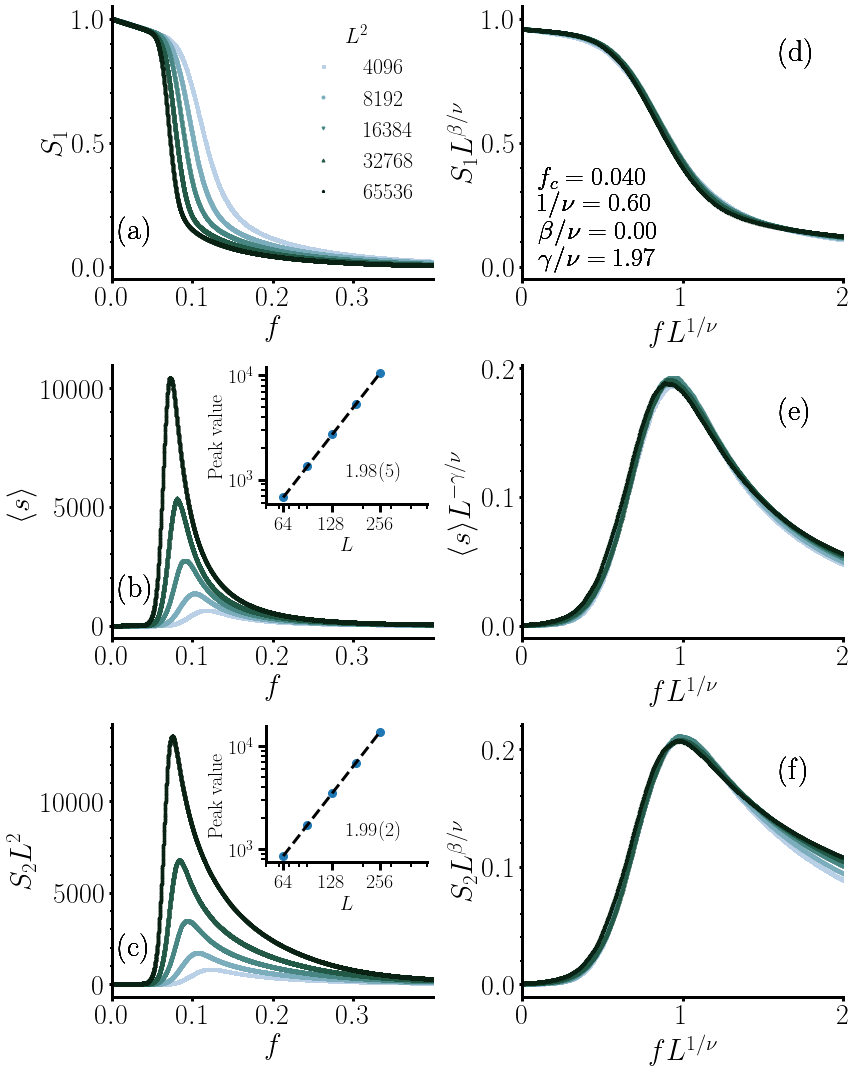

In [78]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.4)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')

ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.02, 0.15, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.02, 0.15, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.02, 0.15, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
if False:
    one_over_nu = 0.4
    gamma_over_nu = 2
    beta_over_nu = 0
    fc = 0.0
else:
    one_over_nu = 0.6
    gamma_over_nu = 1.97
    beta_over_nu = 0
    fc = 0.04
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,1]
    ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

    ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    ax.text(
        0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
        transform=ax.transAxes, fontsize=26
    )
    ax.text(
        0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
        transform=ax.transAxes, fontsize=26
    )

    ax = axes[1,1]
    ax.text(0.8, 0.8, letters[1+3], transform=ax.transAxes, fontsize=30)
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )  

    ax = axes[2,1]
    ax.text(0.8, 0.8, letters[2+3], transform=ax.transAxes, fontsize=30)
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

## Insets

bbox_to_anchor = (.52, .54, .5, .5)
axins1 = inset_axes(axes[1,0], width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=axes[1,0].transAxes)

axins2 = inset_axes(axes[2,0], width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=axes[2,0].transAxes)

axinses = [axins1, axins2]

attack = 'Btw'
measures = [
    'meanS', 'Nsec'
]

for ax in axinses:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(50, 500)
    ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):
    ax = axinses[i]
    #ax.set_ylabel(r'$\max\;$' + measures_dict[measure], fontsize=20)
    ax.set_ylabel(r'$\mathrm{Peak\;value}$', fontsize=20)
    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    
    
    markers1, = ax.plot(
        L_values, measure_values, 'o', #marker_dict[measure], 
        #color=color_dict[measure], 
        markersize=8, 
        #label=measures_dict[measure]
    )
    
    c = measure_values[-1] / L_values[-1]**slope
    label = r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
    ax.plot(
        L_values, powerlaw(L_values, slope, c), '--', color='k', 
        #label=label
    )
    ax.text(0.5, 0.2, label, transform=ax.transAxes, fontsize=20)
    #ax.legend(frameon=False, fontsize=20, loc=(0.3,0.05))
    
#axes[1,0].axvline(0.5, 0.4, 0.5, transform=axes[1,0].transAxes)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_twoCols_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### Comp size distribution

In [16]:
size = 16384
gcc = False
f_values = {
    16384: 0.08338,
    65536: 0.06786
}
f_value = f_values[size]
net_dir_name = '../networks/DT/DT_param'.format(param)
base_net_name = 'DT_param_N{}'.format(size)
base_net_dir_name = os.path.join(net_dir_name, base_net_name)

if gcc:
    comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
else:
    comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)

In [17]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
sizes = [8192, 16384, 32768, 65536, 131072]
#sizes = [65536]
gcc = True

f_values_dict = {
    131072: ['0.06097', '0.06737', '0.06874'],
    65536: ['0.06786', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ['0.09316', '0.10266', '0.10789']
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    print(N)
    f_value = f_values_dict[N][0]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

print(nseeds_values)

8192
16384
32768
65536
131072
{8192: 10000, 16384: 10000, 32768: 10000, 65536: 10000, 131072: 1000}


0.93214


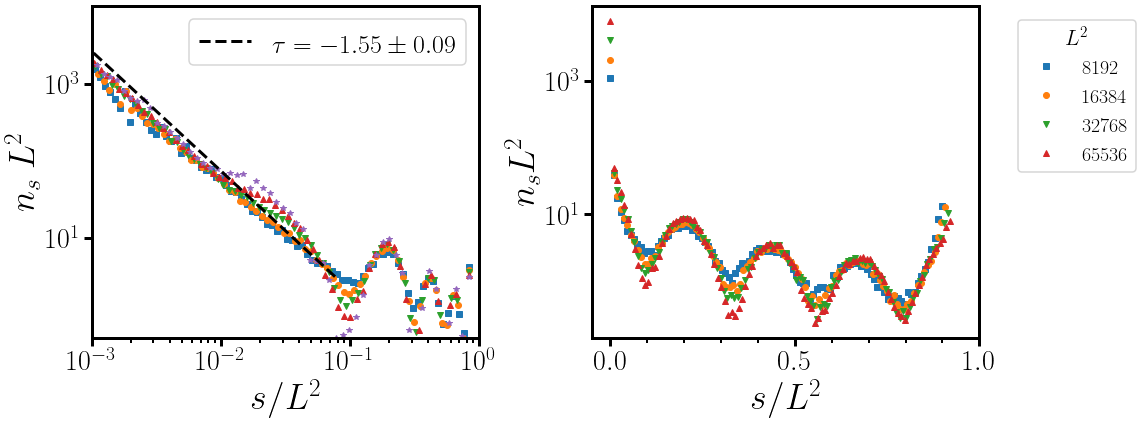

In [21]:
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for ax in axes:
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
ax = axes[0]
ax.set_xlim(1e-3, 1)
ax.set_ylim(0.5, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    
    X = X / N
    Y = Y * N / nseeds_values[N]
    #Y = Y*N**2
    
    ax.plot(
        X, Y, marker=markers[i], linestyle=''
    )
    if N == sizes[-1]:
        _X = X[5:-20]
        _Y = Y[5:-20]
        Y_pred, slope, y_err = getLinearReg(_X, _Y)
        label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(_X, Y_pred, '--', color='k', label=label)

ax.legend()      

ax = axes[1]
#ax.set_xscale('log')
ax.set_xlim(-0.05, 1)
#ax.set_ylim(1e3, 1e6)
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes[:-1]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    X = X / N
    Y = Y * N / nseeds_values[N]
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N)
    ) 
legend = ax.legend(loc=(01.1, 0.5), fontsize=20)
legend.set_title(r'$L^2$', prop={'size':22})

c = 0.20
c_max = 1-float(f_values_dict[65536][0])
print(c_max)
N = 32768
for ax in axes:
    #ax.axvline(c, color='k', linestyle=':')
    #ax.axvline(0.44, color='k', linestyle=':')
    #ax.axvline(0.68, color='k', linestyle=':')
    #ax.axvline(c_max-0.27, color='k', linestyle=':')
    #ax.axvline(c_max, color='k', linestyle=':')
    #ax.axvline(4*c, color='k', linestyle=':')
    #for i in range(10):
    #    ax.axvline((1-rc_values[N][i])*delta_values[N][i], color='k', linestyle=':')
        #ax.axvline((rc_values[N][i])*delta_values[N][i], color='k', linestyle=':')
        #ax.axvline((1-rc_values[N][i])-delta_values[N][i], color='k', linestyle=':')
    pass
    
    
plt.tight_layout()
if gcc:
    base_name = 'ns_scaled_B_gcc_{}'.format(net_type)
else:
    base_name = 'ns_scaled_B_{}'.format(net_type)
    

fig_name = os.path.join(fig_dir, base_name)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

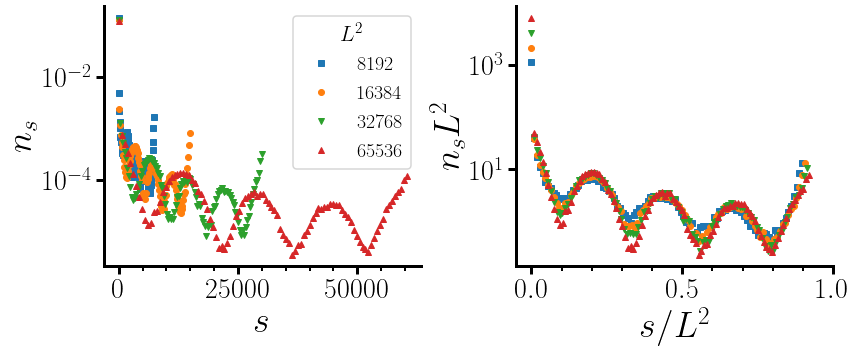

In [22]:
ncols = 2
fig, axes = plt.subplots(figsize=(6*ncols,5), ncols=ncols)

ax = axes[0]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
#ax.set_xlim(-0.05, 1)
#ax.set_ylim(1e3, 1e6)
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, N in enumerate(sizes[:-1]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    X = X 
    Y = Y / nseeds_values[N]
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N)
    ) 
legend = ax.legend(loc='best', fontsize=20)
legend.set_title(r'$L^2$', prop={'size':22})


ax = axes[1]
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
ax.set_xlim(-0.05, 1)
#ax.set_ylim(1e3, 1e6)
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes[:-1]):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 100   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    X = X / N
    Y = Y * N / nseeds_values[N]
    
    ax.plot(
        X, Y, marker=markers[i], linestyle=''#, label=r'${{{}}}$'.format(N)
    ) 

plt.tight_layout()
if gcc:
    base_name = 'ns_scaled_B_gcc_linear_{}'.format(net_type)
else:
    base_name = 'ns_scaled_B_linear_{}'.format(net_type)
    
sns.despine()
fig_name = os.path.join(fig_dir, base_name)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

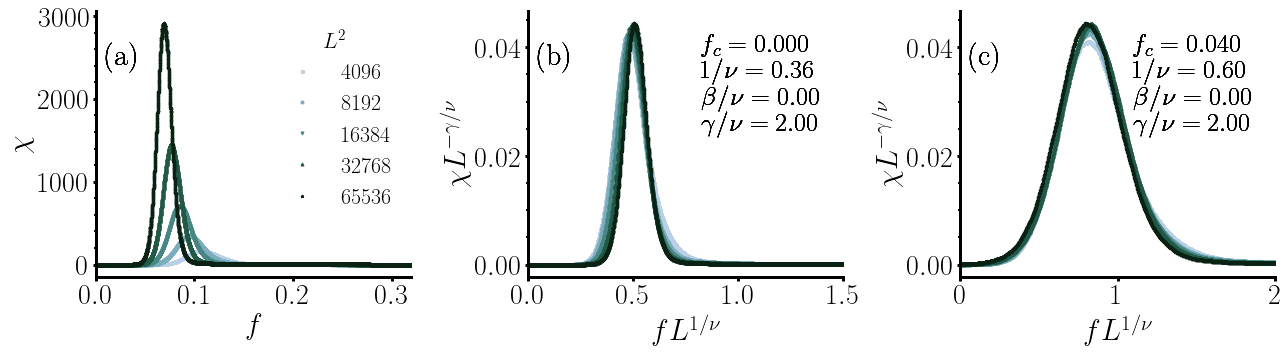

In [23]:
attack = 'Btw'
sizes = [4096, 8192, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
ax = axes[0]
ax.set_xlim(0, 0.32)
ax.set_xticks([0.0, 0.1, 0.2, 0.3])
ax.set_xlabel(r'$f$')
ax = axes[1]
ax.set_xlim(0, 1.5)
ax.set_xlabel(r'$f L^{1/\nu}$')
ax = axes[2]
ax.set_xlim(0, 2)
ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0]
ax.set_ylabel(r'$\chi$')

for i in [1, 2]:
    ax = axes[i]
    ax.set_ylabel(r'$\chi L^{-\gamma/\nu}$')

        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0]
    ax.text(0.03, 0.8, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.varSgcc, linestyle='', marker=markers[i], markersize=3, color=colormap[i],
        label=r'${{{}}}$'.format(N)
    )
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.36
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.6
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.04
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)
        ax = axes[j]
        ax.text(
            0.55, 0.85, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.75, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.65, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.55, 0.55, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        
        ax.text(0.03, 0.8, letters[j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.varSgcc*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

legend = axes[0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_chi_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

### $\mathrm{IB}q$ attacks

In [88]:
sizes = [
    128, 256, 512, 
    1024, 2048, 4096, 8192, 
    16384, 32768, 65536, 131072
]
l_values = np.arange(2, 200)
nseeds = 1000
rc_values, rc_values_std = get_rc_values(
    sizes, l_values=l_values, 
    min_nseeds=100, 
    #nseeds=nseeds,
    base_attack='Btw'
)
l_cutoff = get_l_cutoff(
    sizes, threshold=1e-2, rc_values=rc_values,
    base_attack='Btw'
)
print(l_cutoff)

INFO: 06/01/2021 03:14:15 PM 128
INFO: 06/01/2021 03:14:54 PM 256
INFO: 06/01/2021 03:15:29 PM 512
INFO: 06/01/2021 03:16:01 PM 1024
INFO: 06/01/2021 03:16:32 PM 2048
INFO: 06/01/2021 03:17:04 PM 4096
INFO: 06/01/2021 03:17:48 PM 8192
INFO: 06/01/2021 03:18:22 PM 16384
INFO: 06/01/2021 03:18:31 PM 32768
INFO: 06/01/2021 03:18:37 PM 65536
INFO: 06/01/2021 03:18:43 PM 131072


{128: 4, 256: 7, 512: 11, 1024: 16, 2048: 22, 4096: 31, 8192: 42, 16384: 57, 32768: 80, 65536: 115}


In [89]:
l_cutoff[65536] = 110
l_cutoff[131072] = np.nan

IndexError: index 4096 is out of bounds for axis 0 with size 8

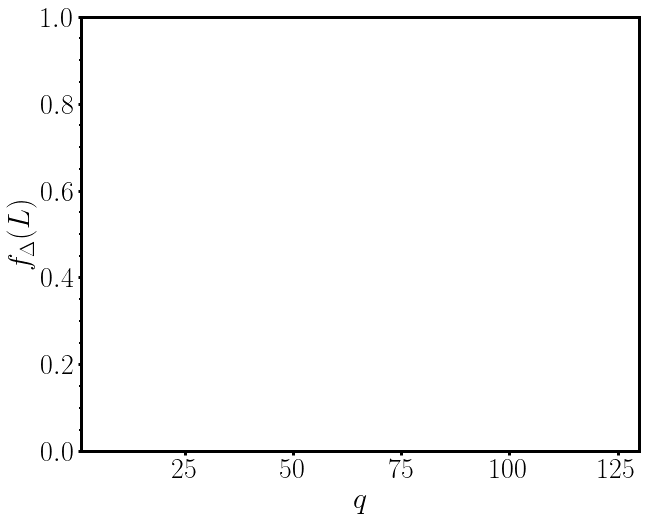

In [79]:
xlim = 1., 130

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols,8*nrows), ncols=ncols, nrows=nrows)

ax.set_xlim(xlim)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$f_{\Delta}(L)$')

_sizes = [size for size in sizes if size > 1000]

colormap = sns.cubehelix_palette(
    len(_sizes), start=2, rot=0.3, light=0.8, dark=0.1
)

for i, size in enumerate(_sizes): 
    L = np.sqrt(size)
    mask = ~np.isnan(rc_values[size][1:])
    
    X = l_values[mask]
    Y = rc_values[size][1:][mask]
    Y_std = rc_values_std[size][1:][mask]
    
    try:
        l_cutoff_idx = np.where(X == l_cutoff[size])[0][0] + 7
    except:
        l_cuotff_idx = -1
    
    X, Y, Y_std = X[:l_cutoff_idx], Y[:l_cutoff_idx], Y_std[:l_cutoff_idx] 

    ax.plot(X, Y, '--' + markers[i], 
            color=colormap[i],
            fillstyle='none',
            label=r'${{{}}}$'.format(size)
    )
    if size in l_cutoff:
        ax.axhline(
            rc_values[size][0],
            0, 
            1.2*l_cutoff[size]/xlim[1],
            linestyle=':', 
            #color=f'C{i}'
            color=colormap[i]
        )
    else:
        ax.axhline(
            rc_values[size][0],
            linestyle=':', 
            #color=f'C{i}'
            color=colormap[i]
        )
    ax.plot(
        l_cutoff[size], rc_values[size][0], 
        'o', markersize=8, color='C3', zorder=100
    )
legend = ax.legend(loc='best', fontsize=20)
legend.set_title(r'$L^2$', prop={'size':22})
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)


_sizes = [key for key in l_cutoff.keys() if key > 1024]

## Standard
X = np.sqrt(_sizes)
Y = np.array([l_cutoff[size] for size in _sizes])

bbox_to_anchor = (.40, .55, .35, .45)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)

axins.set_xscale('log')
axins.set_yscale('log')
axins.plot(X, Y, 'o', color='C3', markersize=8)

X = X[:-1]
Y = Y[:-1]
Y_pred, slope, y_err = getLinearReg(X, Y)

c = Y_pred[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)

#label = r'$\alpha = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
label = r'$\alpha = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
axins.plot(X, Y_pred, '--', color='k', label=label)
axins.text(0.55, 0.15, r'$q^* \sim L^{\alpha}$', fontsize=30, transform=axins.transAxes)

_c = Y_pred[-3] / X[-3]
_Y_pred = powerlaw(X, 1, _c)

label = r'$\mathrm{slope} = 1$' 

axins.set_xlim(28, 270)
axins.set_xticks([32, 64, 128, 256])
axins.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

axins.set_ylim(15, 155)
axins.set_yticks([16, 32, 64, 128])
axins.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
axins.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

axins.legend(loc=(0.02, 0.87), frameon=False, fontsize=22)

axins.set_xlabel(r'$L$', fontsize=30)
axins.set_ylabel(r'$q^*$', fontsize=30)

sns.despine()
fig_name = os.path.join(fig_dir, 'peak_shifting_Bl_rc_{}_a'.format(net_type))
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

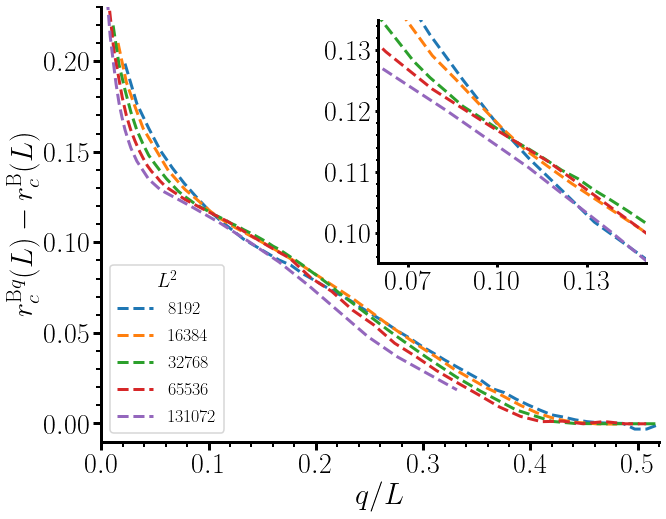

In [26]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
#ax.set_xlim(0, 0.8)
#ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yscale('log')
#ax.set_ylim(1e-9, 1)
#ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

#ax.set_xlabel(r'$\ell/L^{\alpha}$')
ax.set_xlabel(r'$q/L$')
#ax.set_ylabel(r'$r^{\mathrm{B}\ell}_c - r^{\mathrm{B}}_c$')
ax.set_ylabel(r'$r^{\mathrm{B}q}_c(L) - r^{\mathrm{B}}_c(L)$')

_l_cutoff = {
    k: v for k, v in l_cutoff.items()
}
crossing = 0.104
alpha = 1
#alpha = 0
_sizes = [size for size in sizes if size > 4800]
#_sizes = [8192]
#_sizes = [16384]
l_cutoff_interp = {}
for i, size in enumerate(_sizes):
    
    
    mask = ~np.isnan(rc_values[size][1:])
    #X = _l_cutoff[size] - l_values[mask]
    L = np.sqrt(size)
    X = l_values[mask]*L**(-alpha)
    #X = l_values[mask] - l_cutoff[size]
    Y = rc_values[size][1:][mask] - rc_values[size][0]
    #th = 1e-6
    #Y[Y<0] = th
    
    mask = X>0
    X = X[mask]
    Y = Y[mask]#*size
    ax.plot(
        X,
        #(X-crossing),#*L**(-0.15), 
        Y, 
        '--',# + markers[i], 
        #markers[i],
        color=f'C{i}',
        label=r'${{{}}}$'.format(size), 
        #fillstyle='none'
    )

#ax.text(0.6, 0.85, r'$\alpha = {{{}}}$'.format(alpha), fontsize=30, transform=ax.transAxes)
legend = ax.legend(loc='lower left', fontsize=18)
legend.set_title(r'$L^2$', prop={'size':20})

#ax.axvline(crossing, color='gray')

ax.set_ylim(-0.01, 0.23)
if alpha == 1:
    ax.set_xlim(0.0, 0.52)
else:
    ax.set_ylim(0.0, 0.8)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

## Crossing
#ax.set_ylim(0.1, 0.15)
#ax.set_xlim(0.05, 0.15)

bbox_to_anchor = (.52, .44, .48, .56)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)
axins.set_xlim(0.06, 0.15)
axins.set_ylim(0.095, 0.135)
axins.set_xticks([0.07, 0.10, 0.13])
axins.set_yticks([0.1, 0.11, 0.12, 0.13])
for i, size in enumerate(_sizes):
    
    mask = ~np.isnan(rc_values[size][1:])
    L = np.sqrt(size)
    X = l_values[mask]*L**(-alpha)

    Y = rc_values[size][1:][mask] - rc_values[size][0]

    mask = X>0
    X = X[mask]
    Y = Y[mask]
    axins.plot(
        X, Y, 
        '--',# + markers[i], 
        color=f'C{i}',
        label=r'${{{}}}$'.format(size)
    )

sns.despine()
fig_name = os.path.join(fig_dir, 'phase_diagram_Bl_{}'.format(net_type))
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

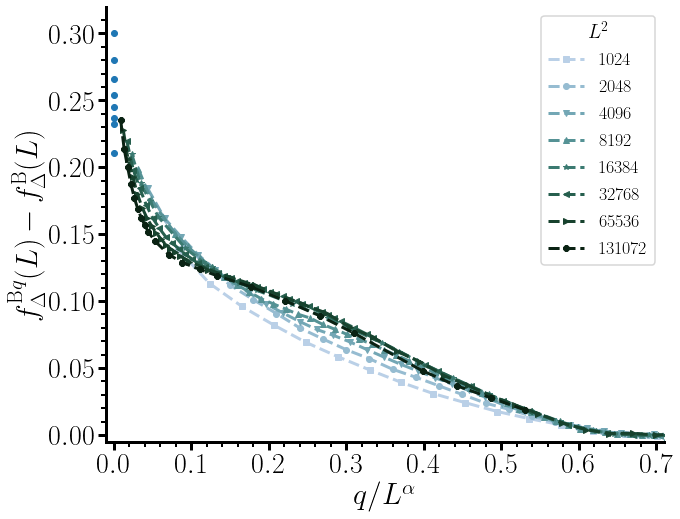

In [90]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
#ax.set_xlim(0, 0.8)
#ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yscale('log')
#ax.set_ylim(1e-9, 1)
#ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

#ax.set_xlabel(r'$\ell/L^{\alpha}$')
ax.set_xlabel(r'$q/L^{\alpha}$')
#ax.set_ylabel(r'$r^{\mathrm{B}\ell}_c - r^{\mathrm{B}}_c$')
ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)-f^{\mathrm{B}}_{\Delta}(L)$')
ax.set_xlim(-0.01, 0.71)
ax.set_ylim(-0.005, 0.32)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
_l_cutoff = {
    k: v for k, v in l_cutoff.items()
}
crossing = 0.104
alpha = 0.92
#alpha = 0
_sizes = [size for size in sizes if size > 1000]
#_sizes = [8192]
#_sizes = [16384]
l_cutoff_interp = {}
for i, size in enumerate(_sizes):
    
    mask = ~np.isnan(rc_values[size][1:])

    L = np.sqrt(size)
    X = l_values[mask]*L**(-alpha)
    Y = rc_values[size][1:][mask] - rc_values[size][0]
    #th = 1e-6
    #Y[Y<0] = th
    
    mask = X>0
    X = X[mask]
    Y = Y[mask]#*size
    ax.plot(
        X, Y, 
        #'-',
        '--' + markers[i], 
        #markers[i],
        #color=f'C{sizes.index(size)-3}',
        color=colormap[len(colormap)-len(_sizes)+i],
        label=r'${{{}}}$'.format(size), 
        #fillstyle='none'
    )
#ax.set_yscale('log')
ax.plot([0]*len(mean_fc_values[:15]), mean_fc_values[:15], 'o')
legend = ax.legend(loc='best', fontsize=18)
legend.set_title(r'$L^2$', prop={'size':20})

sns.despine()
fig_name = os.path.join(fig_dir, '_phase_diagram_Bl_{}_alpha{}'.format(net_type, alpha))
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

<ipython-input-82-523fc3f152cb>:174: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


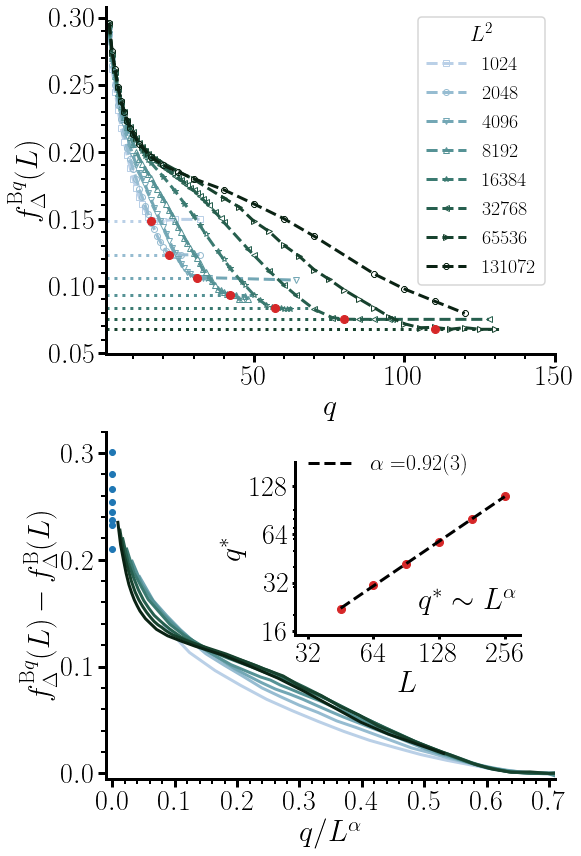

In [82]:
xlim = 1., 150

ncols = 1
nrows = 2
fig, axes = plt.subplots(figsize=(8*ncols,6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xlim(xlim)
ax.set_xlabel(r'$q$')
ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)$')

_sizes = [size for size in sizes if size > 1000]

colormap = sns.cubehelix_palette(
    len(_sizes), start=2, rot=0.3, light=0.8, dark=0.1
)

for i, size in enumerate(_sizes): 
    L = np.sqrt(size)
    mask = ~np.isnan(rc_values[size][1:])
    
    X = l_values[mask]
    Y = rc_values[size][1:][mask]
    Y_std = rc_values_std[size][1:][mask]
    
    try:
        l_cutoff_idx = np.where(X == l_cutoff[size])[0][0] + 7
    except:
        l_cuotff_idx = -1
    
    X, Y, Y_std = X[:l_cutoff_idx], Y[:l_cutoff_idx], Y_std[:l_cutoff_idx] 

    #if size in [1024, 4096, 16384, 65536]:
    if True:
        label = r'${{{}}}$'.format(size)
    else:
        label = ''
    ax.plot(X, Y, '--' + markers[i], 
            color=colormap[i],
            fillstyle='none',
            label=label
    )
    if size in l_cutoff:
        ax.axhline(
            rc_values[size][0],
            0, 
            1.2*l_cutoff[size]/xlim[1],
            linestyle=':', 
            #color=f'C{i}'
            color=colormap[i]
        )
    else:
        ax.axhline(
            rc_values[size][0],
            linestyle=':', 
            #color=f'C{i}'
            color=colormap[i]
        )
    ax.plot(
        l_cutoff[size], rc_values[size][0], 
        'o', markersize=8, color='C3', zorder=100
    )
legend = ax.legend(loc='best', fontsize=20)
legend.set_title(r'$L^2$', prop={'size':22})
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

ax = axes[1]

_sizes = [key for key in l_cutoff.keys() if key > 1024]

## Standard
X = np.sqrt(_sizes)
Y = np.array([l_cutoff[size] for size in _sizes])

X = X[:-1]
Y = Y[:-1]

bbox_to_anchor = (.45, .45, .5, .5)
axins = inset_axes(ax, width="100%", height="100%",
        bbox_to_anchor=bbox_to_anchor,
        bbox_transform=ax.transAxes)

axins.set_xscale('log')
axins.set_yscale('log')
axins.plot(X, Y, 'o', color='C3', markersize=8)

Y_pred, slope, y_err = getLinearReg(X, Y)

c = Y_pred[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)

#label = r'$\alpha = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
label = r'$\alpha = $' + r'${{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
axins.plot(X, Y_pred, '--', color='k', label=label)
axins.text(0.55, 0.15, r'$q^* \sim L^{\alpha}$', fontsize=30, transform=axins.transAxes)

_c = Y_pred[-3] / X[-3]
_Y_pred = powerlaw(X, 1, _c)

axins.set_xlim(28, 300)
axins.set_xticks([32, 64, 128, 256])
axins.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
axins.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

axins.set_ylim(15, 180)
axins.set_yticks([16, 32, 64, 128])
axins.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
axins.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

axins.legend(loc=(0.02, 0.87), frameon=False, fontsize=22)

axins.set_xlabel(r'$L$', fontsize=30)
axins.set_ylabel(r'$q^*$', fontsize=30)


ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xscale('log')
#ax.set_xlim(0, 0.8)
#ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
#ax.set_yscale('log')
#ax.set_ylim(1e-9, 1)
#ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
#ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

#ax.set_xlabel(r'$\ell/L^{\alpha}$')
ax.set_xlabel(r'$q/L^{\alpha}$')
#ax.set_ylabel(r'$r^{\mathrm{B}\ell}_c - r^{\mathrm{B}}_c$')
ax.set_ylabel(r'$f^{\mathrm{B}q}_{\Delta}(L)-f^{\mathrm{B}}_{\Delta}(L)$')
ax.set_xlim(-0.01, 0.71)
ax.set_ylim(-0.005, 0.32)
ax.set_xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
_l_cutoff = {
    k: v for k, v in l_cutoff.items()
}
crossing = 0.104
alpha = 0.92
#alpha = 0
_sizes = [size for size in sizes if size > 1000]
#_sizes = [8192]
#_sizes = [16384]
l_cutoff_interp = {}
for i, size in enumerate(_sizes):
    
    mask = ~np.isnan(rc_values[size][1:])

    L = np.sqrt(size)
    X = l_values[mask]*L**(-alpha)
    Y = rc_values[size][1:][mask] - rc_values[size][0]
    #th = 1e-6
    #Y[Y<0] = th
    
    mask = X>0
    X = X[mask]
    Y = Y[mask]#*size
    ax.plot(
        X, Y, 
        '-',
        #'--' + markers[i], 
        #markers[i],
        #color=f'C{sizes.index(size)-3}',
        color=colormap[len(colormap)-len(_sizes)+i],
        label=r'${{{}}}$'.format(size), 
        #fillstyle='none'
    )
#ax.set_yscale('log')
ax.plot([0]*len(mean_fc_values[:15]), mean_fc_values[:15], 'o')

sns.despine()
plt.tight_layout()

fig_name = os.path.join(fig_dir, 'phase_diagram_Bl_{}_alpha{}'.format(net_type, alpha))
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')
plt.show()

In [22]:
measures = ['meanS', 'Nsec']
attacks = [
    'Ran', 'Deg', 'Btw_cutoff2', 
    'Btw_cutoff3', 'Btw_cutoff4', #'Btw_cutoff5', 
    #'Btw_cutoff6', 'Btw_cutoff7', 
    'Btw_cutoff8'
]

sizes = [4096, 8192, 16384, 32768, 65536, 131072]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    print(attack)
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values, measure_values)
        
        Y, _ = getPeaks(dfs, measure)
        #print(measure)
        #print({N: y for N, y in zip(N_values, Y)})
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err       
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    if False:
        print(
            '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
                attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
                2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
            )
        )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Ran
Deg
Btw_cutoff2
Btw_cutoff3
Btw_cutoff4
Btw_cutoff8


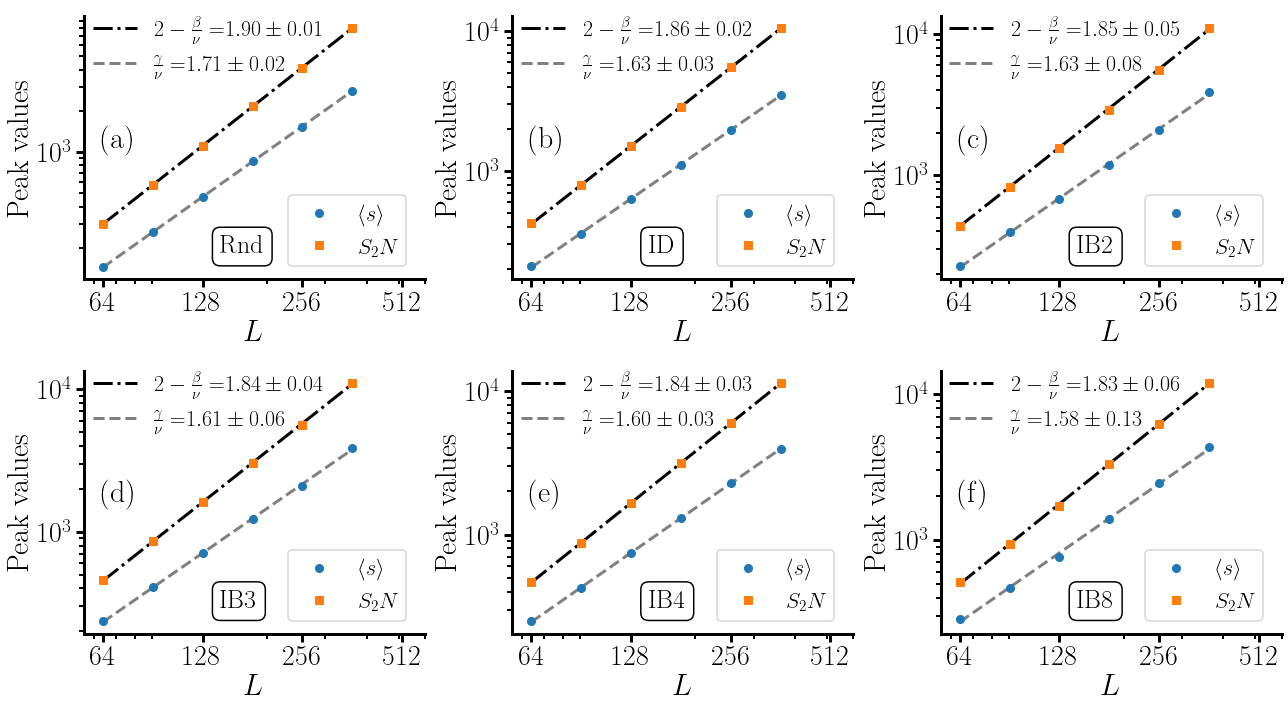

In [23]:
measures = ['meanS', 'Nsec']

ncols = 3
nrows = len(attacks) // ncols + bool(len(attacks) % ncols)
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(56, 600)
    ax.set_xticks([64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
for k, attack in enumerate(attacks):
    ax = axes[k]

    ax.text(0.05, 0.5, letters[k], transform=ax.transAxes, fontsize=30)
    bbox = {'boxstyle': 'round', 'fc': 'None'}
    ax.text(0.4, 0.1, attack_dict[attack], transform=ax.transAxes, fontsize=26, bbox=bbox)
    ax.set_ylabel(r'$\mathrm{Peak\;values}$')

    for i, measure in enumerate(measures):

        L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

        if measure == 'meanS':
            label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label1 = label
            line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)

        elif measure == 'Nsec':
            label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
            label2 = label
            line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

        markers1, = ax.plot(
            L_values, measure_values, marker_dict[measure], 
            color=color_dict[measure], markersize=8, 
            label=measures_dict[measure]
        )

    handles, labels = ax.get_legend_handles_labels()
    ## Markers
    order = [1, 3]
    legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.6, 0.05))

    ax.add_artist(legend1)
    ## Lines
    order = [2, 0]
    ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
              fontsize=22, loc=(0.0, 0.73), frameon=False)


sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_Bl_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [8]:
from collections import namedtuple

Params = namedtuple('Param', ['fmin', 'fmax', 'ymin', 'ymax'])

attack_params = {
    'Ran': Params(0.495, 0.505, 3, 7),
    'Deg': Params(0.295, 0.31, 1.4, 8),
    'DegU': Params(0.37, 0.385, 1.4, 8),
    'Btw_cutoff2': Params(0.29, 0.305, 1, 8),
    'Btw_cutoff3': Params(0.265, 0.295, 1, 8),
    'Btw_cutoff4': Params(0.25, 0.28, 1, 8),
    'Btw_cutoff5': Params(0.23, 0.28, 1, 8),
    'Btw_cutoff6': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff7': Params(0.22, 0.26, 1, 8),
    'Btw_cutoff8': Params(0.21, 0.24, 1, 8),
    'Btw_cutoff9': Params(0.20, 0.24, 1, 8),
    'Btw_cutoff10': Params(0.18, 0.24, 1, 8),
    'Btw_cutoff11': Params(0.17, 0.24, 1, 8),
}
for l in range(12, 17):
    attack_params[f'Btw_cutoff{l}'] = Params(0.17, 0.24, 1, 8)

[ 8192 16384 32768 65536]
Ran                 0.49992 +- 0.00025  0.000502
[ 2048  4096  8192 16384]
Deg                 0.30570 +- 0.00095  0.003094
[ 2048  4096  8192 16384]
Btw_cutoff2         0.29964 +- 0.00004  0.000118
[ 2048  4096  8192 16384]
Btw_cutoff3         0.27975 +- 0.00061  0.002177
[2048 4096 8192]
Btw_cutoff4         0.27108 +- 0.00230  0.008483
[2048 4096 8192]
Btw_cutoff8         0.23987 +- 0.00006  0.000240


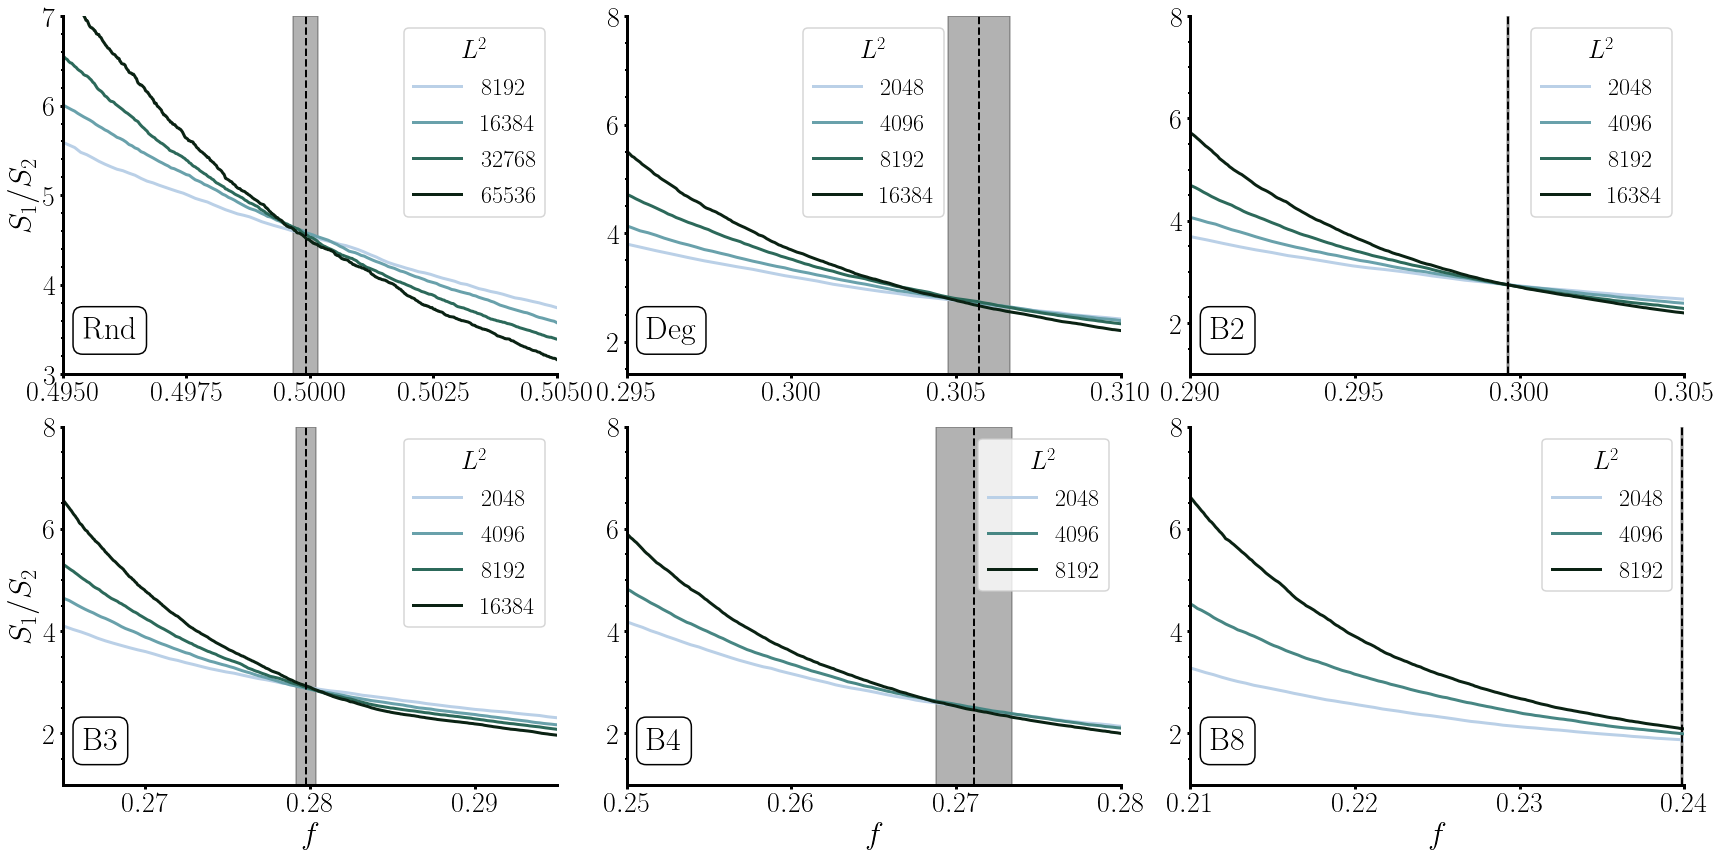

In [10]:
def plot_S1_over_S2(net_type, attacks):
    
    ncols = 3
    nrows = len(attacks) // ncols 
    if len(attacks) % ncols:
        nrows += 1
    fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
    axes = axes.flatten()

    fc_values = {}
    for j, attack in enumerate(attacks):

        sizes = [
            1024, 2048, 4096, 
            8192, 
            16384, 32768, 65536,
            131072, 262144
        ]  
        
        dfs = {}
        for N in sizes:
            try:
                dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=10000)
            except FileNotFoundError:
                continue

        N_values = np.sort(list(dfs.keys()))[-4:]
        L_values = np.sqrt(N_values)
        print(N_values)
        dfs = {N: dfs[N] for N in N_values}
        
        ax = axes[j]
        fmin, fmax, ymin, ymax = attack_params[attack]
        ax.set_xlim(fmin, fmax)
        ax.set_ylim(ymin, ymax)
        if (j % ncols) == 0:
            ax.set_ylabel(r'$S_1/S_2$', fontsize=32)
        if j >= ncols*(nrows-1):
            ax.set_xlabel(r'$f$', fontsize=32)

        colors = sns.cubehelix_palette(
            len(N_values), start=2, rot=0.3, 
            light=0.8, dark=0.1
        )
        for i, N in enumerate(N_values):
            df = dfs[N]
            S1_over_S2 = N * df.Sgcc / df.Nsec
            ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])
        
        if not dfs: ## Dict is empty
            continue

        mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False, method='beta')
        
        fc_values[attack] = (mean_fc, std_fc)
        
        print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))
        
        ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
        ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    
        bbox = {'boxstyle': 'round', 'fc': 'None'}
        ax.text(0.04, 0.1, attack_dict[attack], fontsize=32, transform=ax.transAxes, bbox=bbox, 
                horizontalalignment='left')
        #ax.text(0.04, 0.12, letters[j], fontsize=36, transform=ax.transAxes, 
        #        horizontalalignment='left')
        legend = ax.legend(loc='best', fontsize=24)
        legend.set_title(r'$L^2$', prop={'size':26})

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_B_' + net_type)
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf')
    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
attacks = ['Ran', 'Deg'] + ['Btw_cutoff%d' % l for l in range(2, 17)]
attacks = ['Ran', 'Deg'] + ['Btw_cutoff%d' % l for l in [2, 3, 4, 8]]
fc_values = plot_S1_over_S2(net_type, attacks)

-0.19+-0.01


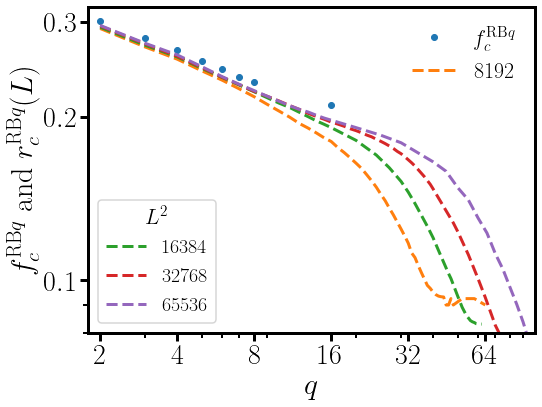

In [23]:
_l_values = []
mean_fc_values = []
for l in range(2, 17):
    attack = f'Btw_cutoff{l}'
    if attack in fc_values:
        mean_fc, std_fc = fc_values[attack]
        
        _l_values.append(l)
        mean_fc_values.append(mean_fc)
        
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_ylabel(r'$f_c^{\mathrm{RB}q}\;\mathrm{and}\; r_c^{\mathrm{RB}q}(L)$')
ax.set_xlabel(r'$q$')
ax.set_xscale('log')
ax.set_yscale('log')

X, Y = _l_values, mean_fc_values
#X = X[:7]
#Y = Y[:7]

Y_pred, slope, y_err = getLinearReg(X[:7], Y[:7])
c = Y[0] / X[0]**slope
label = r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
print('{:.2f}+-{:.2f}'.format(slope, y_err))
#label = r'$f_c^{(\mathrm{RB}\ell)} \sim L^{-\omega}$'
ax.plot(X, Y, 'o', label=r'$f_c^{\mathrm{RB}q}$')
#ax.plot(X, Y_pred, '--', color='k', label=label)
x = np.linspace(1, 64)
y = powerlaw(x, slope, c)
#ax.plot(x, y, '--', color='k', label=label)


ax.set_xlim(1.8, 100)
ax.set_xticks([2, 4, 8, 16, 32, 64])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylim(0.08, 0.32)
ax.set_yticks([0.1, 0.2, 0.3])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


_sizes = [8192, 16384, 32768, 65536]
for i, size in enumerate(_sizes): 
    L = np.sqrt(size)
    mask = ~np.isnan(rc_values[size][1:])
    
    X = l_values[mask] 
    Y = rc_values[size][1:][mask]
    Y_std = rc_values_std[size][1:][mask]
    
    #ax.plot(l_values, rc_values[size][1:], 'o-', 
    ax.plot(
        X, Y, '--', label=r'${{{}}}$'.format(size)
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[2:], labels[2:],
          fontsize=20, loc='lower left')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)
## Lines
ax.legend(handles[:2], labels[:2],
          fontsize=22, loc='upper right', frameon=False)

fig_name = os.path.join(fig_dir, 'f_c_and_r_c_Bl{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

### Phase transition at $q/L=0.25$

In [ ]:
sizes = [512, 1024, 2048, 4096, 8192, 16384]
l_values = np.arange(2, 200)
nseeds = 1000
rc_values, rc_values_std = get_rc_values(
    sizes, l_values=l_values, 
    min_nseeds=100, 
    #nseeds=nseeds,
    base_attack='Btw'
)
l_cutoff = get_l_cutoff(
    sizes, threshold=1e-2, rc_values=rc_values,
    base_attack='Btw'
)
print(l_cutoff)

In [ ]:
net_type = 'DT'
param = 'param'
sizes = [512, 1024, 2048, 4096, 8192, 16384]    
nseeds = 100

l_values = {}
for size in sizes:
    L = np.sqrt(size)
    #l = int(L / 4)
    l = l_cutoff[size] // 4
    l_values[size] = l

nrows = 2
ncols = 1
fig, axes = plt.subplots(figsize=(10*ncols, 5*nrows), nrows=nrows, ncols=ncols)     

dfs = {}
max_means ={}
max_nsec ={}
for i, size in enumerate(sizes):
    l = l_values[size]
    print(size, l)
    attack = f'Btw_cutoff{l}'
    df = load_dataframe(
        net_type, size, param, attack=attack, min_nseeds=nseeds
    )
    max_means[size] = np.max(df.meanS)
    max_nsec[size] = np.max(df.Nsec)
    dfs[size] = df
    
ax = axes[0]
ax.set_ylabel(r'$S_1$')
for i, size in enumerate(sizes):
    df = dfs[size]
    label = attack_dict[attack] if j==0 else ''
    ax.plot(df.f, df.Sgcc, color=f'C{i}', label=label)

ax = axes[1]
ax.set_ylabel(r'$\langle s \rangle$')
for i, size in enumerate(sizes):
    df = dfs[size]
    ax.plot(df.f, df.meanS, color=f'C{i}')



axes[0].legend(
    loc='upper right', fontsize=20
    #oc=(0.9, 0.5)
)
plt.tight_layout()
plt.show()

In [ ]:
def plot_S1_over_S2(net_type):

    ncols = 1
    nrows = 1
    fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

    sizes = [1024, 2048, 4096, 8192, 16384]  

    dfs = {}
    for N in sizes:
        l = l_values[N]
        attack = f'Btw_cutoff{l}'
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue

    N_values = np.sort(list(dfs.keys()))
    L_values = np.sqrt(N_values)

    dfs = {N: dfs[N] for N in N_values}

    fmin = 0.1
    fmax = 0.3
    ymin = 1.
    ymax = 10.     

    ax.set_xlim(fmin, fmax)
    ax.set_ylim(ymin, ymax)

    ax.set_ylabel(r'$S_1/S_2$', fontsize=28)
    ax.set_xlabel(r'$f$', fontsize=28)

    colors = sns.cubehelix_palette(
        len(N_values), start=2, rot=0.3, 
        light=0.8, dark=0.1
    )
    for i, N in enumerate(N_values):
        df = dfs[N]
        S1_over_S2 = N * df.Sgcc / df.Nsec
        ax.plot(df.f, S1_over_S2, '-', label=r'${{{}}}$'.format(N), color=colors[i])

    mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
    print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))

    ax.axvline(mean_fc, linestyle='--', color='k', linewidth=2)
    ax.fill_betweenx([ymin, ymax], mean_fc-std_fc, mean_fc+std_fc, color='k', alpha=0.3)
    ax.legend(loc='best', fontsize=24)

    sns.despine()
    plt.tight_layout()

    fig_name = os.path.join(fig_dir, 'crossing_method_l_over_L_constant_' + net_type)
    plt.savefig(fig_name + '.png', transparent=False)
    plt.savefig(fig_name + '.pdf')
    
    plt.show()
    
    return fc_values
    
net_type = 'DT'
fc_values = plot_S1_over_S2(net_type=net_type)

### IB2 attack

INFO: 05/26/2021 10:36:45 AM NumExpr defaulting to 4 threads.


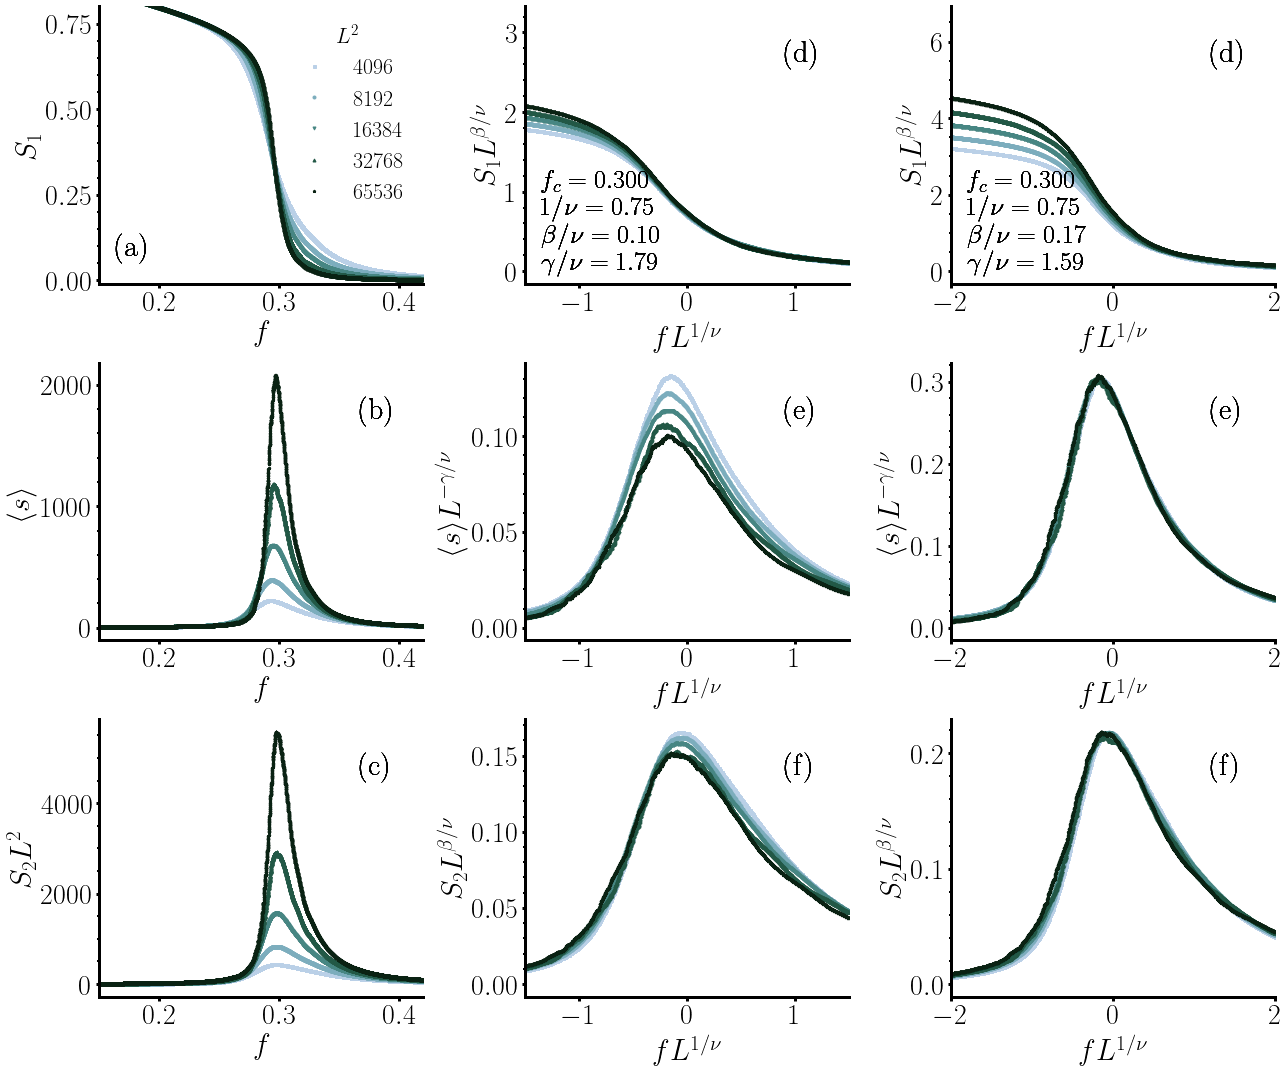

In [6]:
attack = 'Btw_cutoff2'
sizes = [4096, 8192, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0.15, 0.42)
    ax.set_xticks([0.2, 0.3, 0.4])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(-1.5, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(-2, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.set_ylim(-0.01, 0.8)
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.75
        gamma_over_nu = 1.792
        beta_over_nu = 0.104
    else:
        one_over_nu = 0.75
        gamma_over_nu = 1.59
        beta_over_nu = 2 - 1.83
    fc = 0.29965
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[4], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[5], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_Bl2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

NameError: name 'data' is not defined

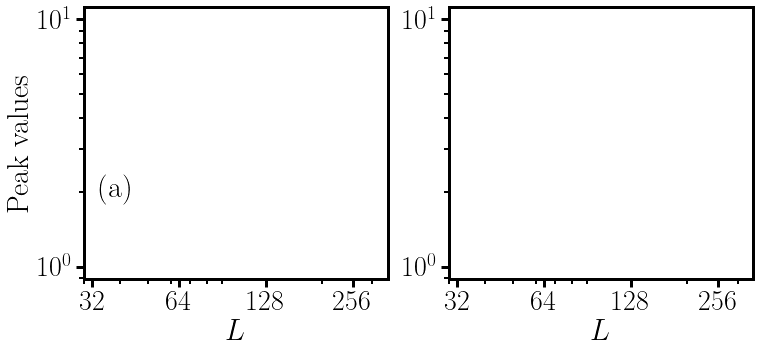

In [2]:
attack = 'Btw_cutoff2'
measures = ['meanS', 'Nsec']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(30, 340)
    ax.set_xticks([32, 64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure == 'meanS':
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)

    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=label_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.29965
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c-f_c(L)$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = fc - np.array(Y)
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_Bl2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [10]:
attack = 'Btw_cutoff2'

sizes = np.array([
    1024, 2048, 4096, 8192, 16384, 32768, 65536#, 131072
                 ])
_sizes = []
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_values, nseeds = load_delta(net_type, N, param, attack, min_nseeds=10000, return_nseeds=True)
        _sizes.append(N)
    except FileNotFoundError:
        print(N)
        continue
         
    nseeds_values.append(nseeds)
    
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

sizes = np.array(_sizes)   
print(sizes, rc_values)

32768
65536
[ 1024  2048  4096  8192 16384] [0.28755957 0.28777129 0.2898467  0.29180048 0.29337915]


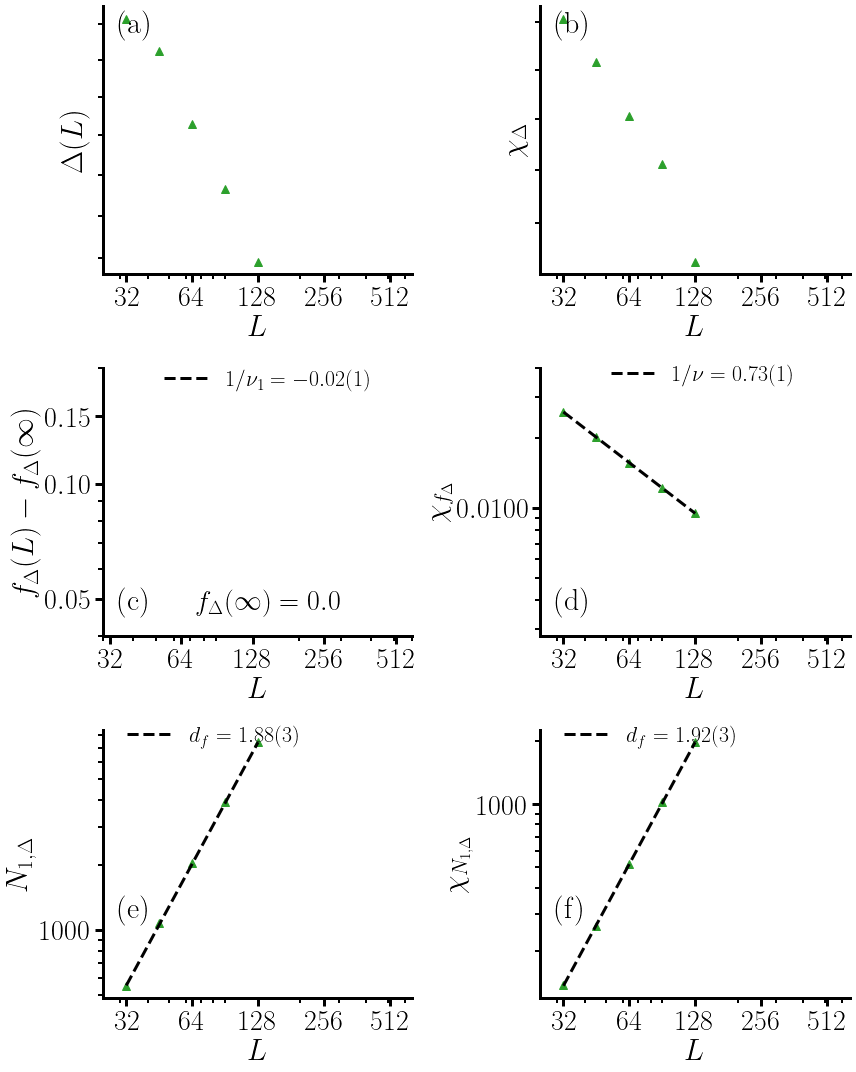

In [12]:
attack = 'Btw_cutoff2'

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(25, 650)
    ax.set_xticks([32, 64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
#ax.set_ylim(0.27, 0.30)
ax.text(0.05, 0.9, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta (L)$')
X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)

###################################################################

ax = axes[1,0]
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
ax.set_ylim(0.04, 0.2)
ax.set_yticks([0.05, 0.1, 0.15])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$f_{\Delta}(L) - f_{\Delta}(\infty)$')
rc = 0.0
X = np.sqrt(sizes)
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = r'$1/\nu_1={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
ax.set_xlim(30, 600)
ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.3, 0.1, r'$f_{\Delta}$' + r'$(\infty)={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
sns.despine()

#############################################################


ax = axes[0,1]
#ax.set_ylim(0.07, 0.085)
ax.text(0.05, 0.9, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
#ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

###############################################################

ax = axes[1,1]
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
ax.set_ylim([0.0028, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{f_{\Delta}}$')
Y = all_std_values[:,0]

Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$1/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err)
label = label=r'$1/\nu={{{:.2f}}}({{{:.0f}}})$'.format(-slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.2, 0.9), frameon=False)

######################################################################

ax = axes[2,0]
ax.text(0.05, 0.3, letters[4], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$N_{1,{\Delta}}$')
Y = all_mean_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f={{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
label = label=r'$d_f={{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

###############################################################

ax = axes[2,1]
ax.text(0.05, 0.3, letters[5], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.04])
#ax.set_yticks([0.003, 0.01, 0.03])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{N_{1,\Delta}}$')
Y = all_std_values[:,2]
Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
c = Y[-1] / X[-1]**slope
ax.plot(X, Y, '^', color='C2', markersize=8)
label = label=r'$d_f = {{{:.2f}}}\pm {{{:.0f}}}$'.format(slope, y_err)
label = label=r'$d_f = {{{:.2f}}}({{{:.0f}}})$'.format(slope, 100*y_err)
ax.plot(
    X, powerlaw(X, slope, c), '--', color='k', 
    label=label
)
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

################################################################

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B2_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

## Fotos

0.9
start plot
Plot backbone
Plot removed
(312, 2)


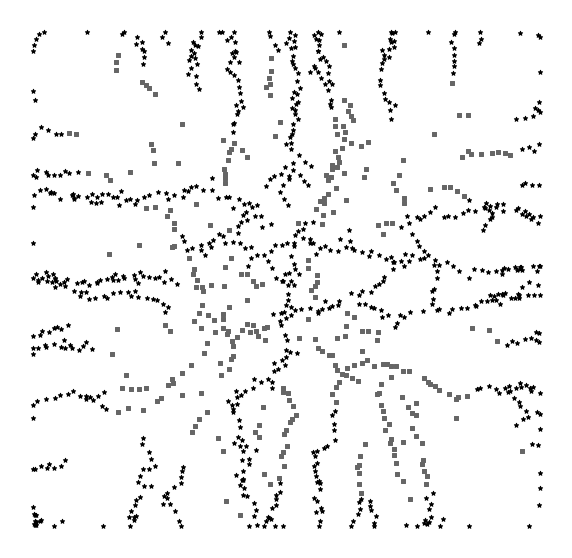

1.0
start plot
Plot backbone
Plot removed
(336, 2)


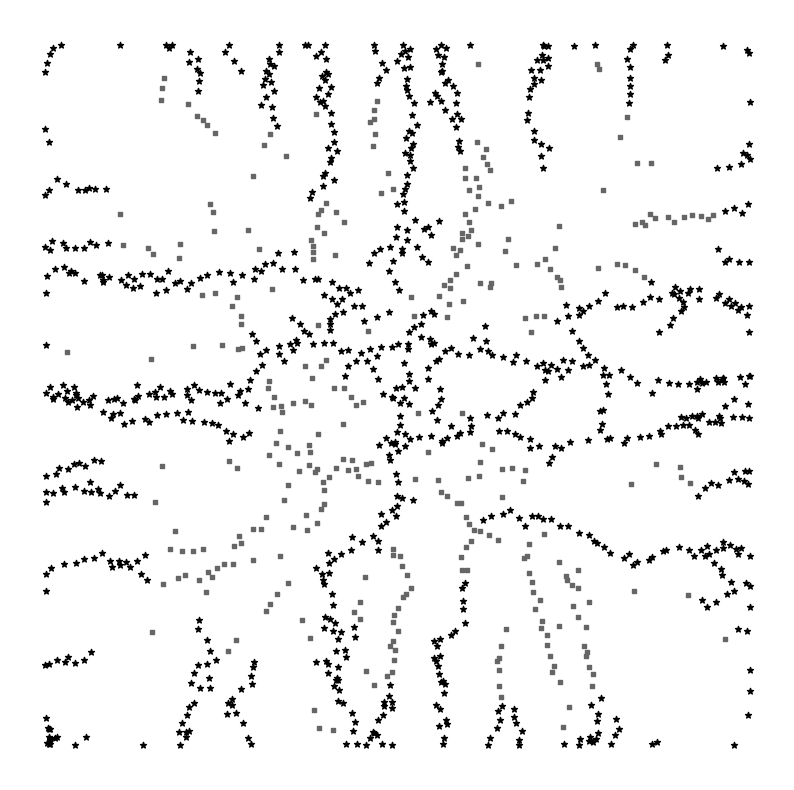

In [11]:
def get_label_dict(g):

    components = g.components(mode='WEAK')
    gcc = components.giant()
    membership = np.array(components.membership)
    number, count = np.unique(membership, return_counts=True)
    number = number[np.argsort(count)[::-1]] 
    label_dict = {i: n for i, n in enumerate(number)}
    reverse_label_dict = {n: i for i, n in enumerate(number)}
    
    return label_dict, reverse_label_dict, membership
    
L = 128
size = L*L
attack = 'Btw_cutoff64'
network = 'DT'
seed = 0

marker_sizes = {
    32: {
        'backbone': 80,
        'removed': 60,
        'components': 40
    },
    64: {
        'backbone': 30,
        'removed': 20,
        'components': 15
    },
    128: {
        'backbone': 20,
        'removed': 10,
        'components': 6
    },
    256: {
        'backbone': 5,
        'removed': 3,
        'components': 1
    },
    512: {
        'backbone': 3,
        'removed': 1,
        'components': 0.1
    },
}

s0 = marker_sizes[L]['backbone']
s1 = marker_sizes[L]['removed']
s2 = marker_sizes[L]['components']

for a in np.arange(.9, 1.01, 0.1):
    print(a)
    ## Spanning subgraph of the removed nodes
    h, max_pos, _ = load_delta_data(network, size, param, attack, seed)
    th = int(a*max_pos)+1

    attack_order = h['attack_order']
    to_delete = set(h.vs['oi']).difference(set(attack_order[:th]))
    h.delete_vertices(to_delete)

    backbone_label_dict, _, backbone_membership = get_label_dict(h)

    backbone_index_dict = {oi: i for i, oi in enumerate(h.vs['oi'])}

    ################

    _colors = [f'C{i}' for i in range(1000)] #+ 10000*['white']
    g, _, _ = load_delta_data(network, size, param, attack, seed)    
    position = np.array(g.vs['position'])
    attack_order = g['attack_order']
    to_delete = set(g.vs['oi']).difference(set(attack_order[th:]))
    g.delete_vertices(to_delete)

    label_dict, reverse_label_dict, membership = get_label_dict(g)

    index_dict = {oi: i for i, oi in enumerate(g.vs['oi'])}

    if False:
        attack_order = g['attack_order']
        g.delete_vertices(attack_order[:th])

        components = g.components(mode='WEAK')
        gcc = components.giant()
        membership = np.array(components.membership)
        number, count = np.unique(membership, return_counts=True)
        number = number[np.argsort(count)[::-1]] 
        count = np.sort(count)[::-1]

        label_dict = dict((i, n) for i,n in enumerate(number))
        for idx in np.where(count==1)[0]:
            label_dict[idx] = -1

    print('start plot')

    def plot_backbone():
        _position = []
        for oi in attack_order[:th]:
            #idx = h.vs['oi'].index(oi)
            idx = backbone_index_dict[oi]
            #if backbone_label_dict[backbone_membership[idx]] == 0:
            if backbone_membership[idx] == backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='k', marker='*', s=s0, zorder=10)

    def plot_removed():
        _position = []
        for oi in attack_order[:th]:
            #idx = h.vs['oi'].index(oi)
            idx = backbone_index_dict[oi]
            if backbone_membership[idx] != backbone_label_dict[0]:
                _position.append(position[oi])
        _position = np.array(_position)
        print(_position.shape)
        X, Y = _position[:,0], _position[:,1]
        plt.scatter(X, Y, c='0.4', marker='s', s=s1, zorder=5)

    def plot_components():
        _position = position[attack_order[th:]]
        X, Y = _position[:,0], _position[:,1]
        c_values = []

        for oi in attack_order[th:]:
            idx = index_dict[oi]
            c_values.append(
                #_colors[reverse_label_dict[membership[idx]]]
                'C{}'.format(reverse_label_dict[membership[idx]]%100)
            )
        print('start scatter', flush=True)
        plt.scatter(
            X, Y, c=c_values, marker='.', s=s2, zorder=0
        )

    def save_fig():
        fig_name = os.path.join(fig_dir, 'breaking_nodes_{}_L{}_{}_{:05d}_th{}_backbone'.format(network, L, attack, seed, th))
        dpi = 100
        plt.savefig(fig_name + '.png', transparent=False, dpi=dpi)
        plt.savefig(fig_name + '.pdf', dpi=dpi)

    fig, ax = plt.subplots(figsize=(10,10))
    #mpl.style.use('default')
    #ax.set_xlabel(r'$x$')
    #ax.set_ylabel(r'$y$')
    #ax.set_xlim(0, L)
    #ax.set_ylim(0, L)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.margins()
    ax.set_facecolor('white')
    sns.despine(bottom=True, left=True)
    print('Plot backbone')
    plot_backbone()
    print('Plot removed')
    plot_removed()
    #print('Plot components')
    #plot_components()
    save_fig()

    plt.show()

In [15]:
attack = 'Btw'

sizes = np.array([
    #256, 
    #512, 1024, 2048, 4096, 
    #8192, 16384, 32768, 
    65536, 
    #131072, 
    #262144
])

nseeds_values = {
    512: 10000,
    1024: 10000,
    2048: 10000,
    4096: 10000,
    8192: 10000,
    16384: 10000,
    32768: 10000,
    65536: 10000,
    131072: 1600,
}
n_deltas = 256
rc_values = {}
delta_values = {}
for i, N in enumerate(sizes):
    try:
        pos_and_delta = load_deltas(
            net_type, N, param, attack, nseeds=nseeds_values[N], n_deltas=n_deltas
        )
    except FileNotFoundError:
        print(N)
        raise

    mean_values = pos_and_delta.mean(axis=0)
    std_values = pos_and_delta.std(axis=0)
    
    rc_values[N] = mean_values[::2]
    delta_values[N] = mean_values[1::2]

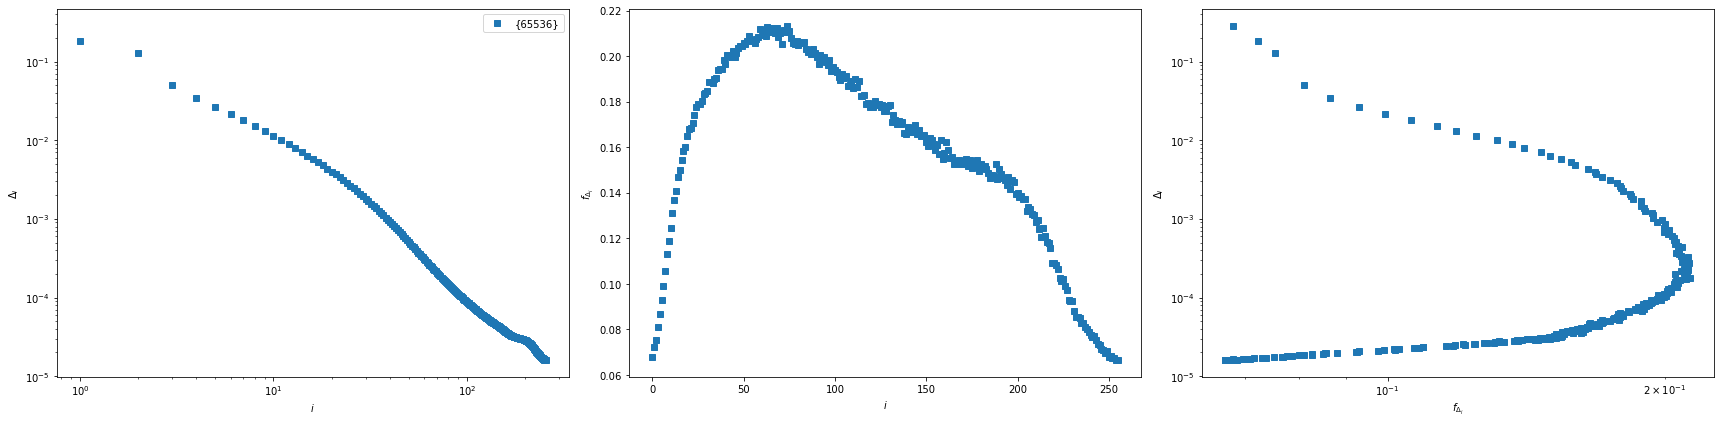

In [18]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
    
ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], delta_values[N], markers[i])

plt.tight_layout()
plt.show()

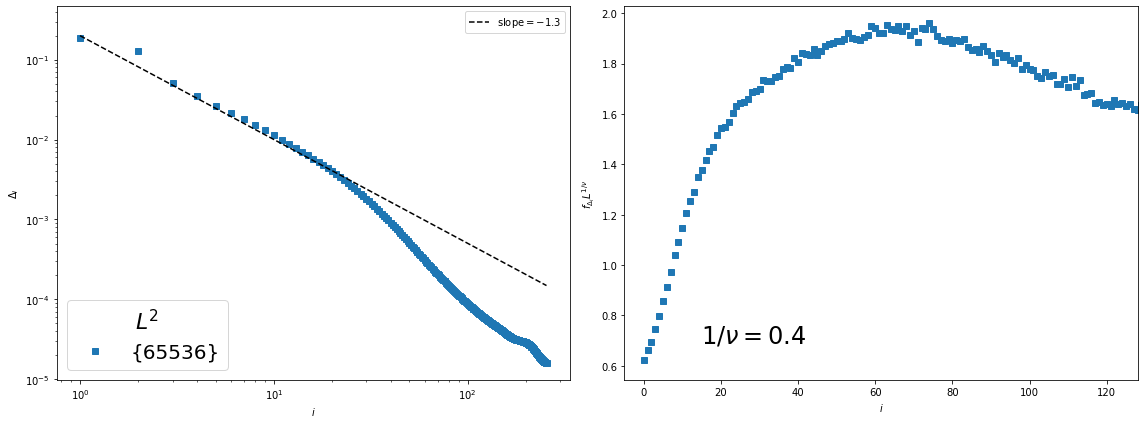

In [19]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))

X = np.arange(1, n_deltas, dtype=float)
slope=-1.3
c=0.2*1e0
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
ax.plot(X, powerlaw(X, slope, c), '--', color='k', label=label)    
    
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles[:-1], labels[:-1],
          fontsize=20, loc='lower left')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.legend(handles[-1:], labels[-1:])

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 128)
one_over_nu = 0.4
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**(one_over_nu), markers[i])
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.15, 0.1, text, transform=ax.transAxes, fontsize=24)

X = np.arange(1, 30)
a = 0.05
b = 0.5
Y = a*X+b
#ax.plot(X, Y, linestyle=':', color='gray')
plt.tight_layout()
plt.show()

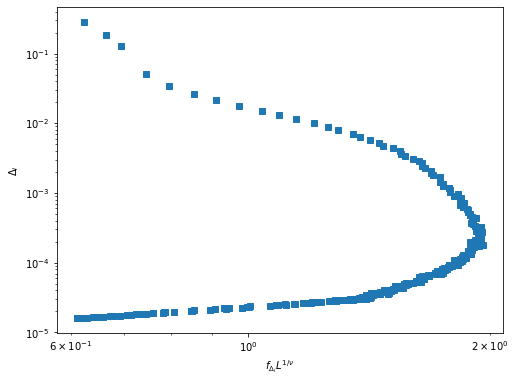

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**one_over_nu, delta_values[N], markers[i])
plt.show()

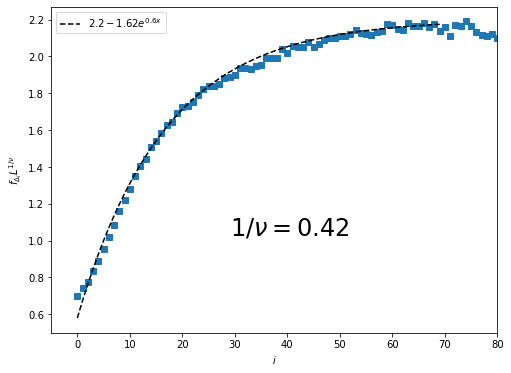

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 80)
#ax.set_yscale('log')
one_over_nu = 0.42
for i, N in enumerate(sizes):
    L = np.sqrt(N)
    ax.plot(rc_values[N]*L**(one_over_nu), markers[i])
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.4, 0.3, text, transform=ax.transAxes, fontsize=24)

def func(x, a, b, c):
    return b-c*np.exp(-a*x)
X = np.arange(0, 70)
a = .06
b = 2.2
c = 1.62
Y = func(X, a, b, c)
label = r'${{{}}}-{{{}}}$'.format(b, c) + r'$e^{0.6 x}$'
plt.plot(X, Y, '--', color='k', label=label)
ax.legend()

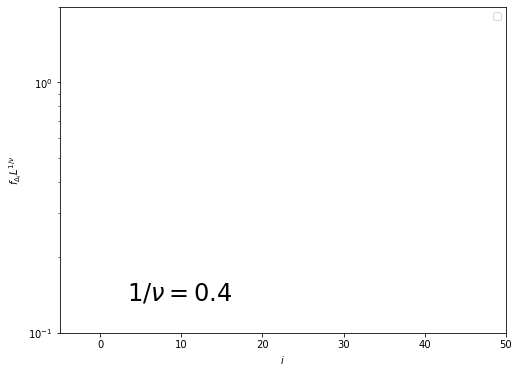

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}L^{1/\nu}$')
ax.set_xlim(-5, 50)
ax.set_ylim(1e-1, 2)
ax.set_yscale('log')
one_over_nu = 0.4
for i, N in enumerate(sizes[3:4]):
    L = np.sqrt(N)
    ax.plot(2-rc_values[N]*L**(one_over_nu), markers[i], label=N)
text = r'$1/\nu={{{}}}$'.format(one_over_nu)
ax.text(0.15, 0.1, text, transform=ax.transAxes, fontsize=24)
ax.legend()

In [23]:
sizes = np.array(list(delta_values.keys()))
L_values = np.sqrt(sizes)
deltas = np.array([
    v for v in delta_values.values()
]).T
rcs = np.array([
    v for v in rc_values.values()
]).T

NameError: name 'deltas' is not defined

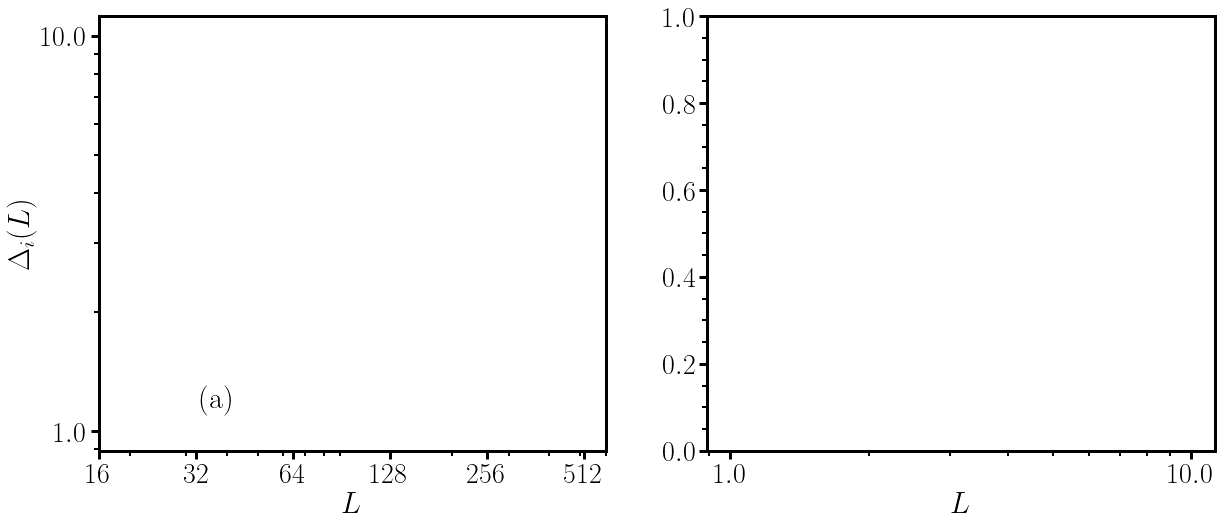

In [43]:
attack = 'Btw'
n_deltas_plot = 8

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
ax.set_yscale('log')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta_i(L)$')

for i in range(n_deltas_plot):
    X = L_values
    Y = deltas[i]
    ax.plot(
        X, 
        Y,
        #deltas[i]/deltas[i][-1], 
        '^-', markersize=8,# label=f'{i}'
    )
    Y_pred, slope, y_err = getLinearReg(X[-5:], Y[-5:])
    c = Y[-1] / X[-1]**slope
    ax.plot(
        X, powerlaw(X, slope, c), '--', color=f'C{i}', 
        label=r'${{{}}} - \beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(i, -slope, y_err)
    )
    
ax.legend()


ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\Delta_i}(L) - f_c$')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])


rc = 0.0
for i in range(n_deltas_plot):
    ax.plot(L_values, rcs[i]-rc, '^-', markersize=8)
    #Y_pred, slope, y_err = getLinearReg(X, Y)
    #ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.text(0.1, 0.25, r'$f_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)

sns.despine()
plt.tight_layout()
#fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')

plt.show()

In [25]:
attack = 'Ran'

sizes = np.array([
    #256, 512, 
    1024, 2048, 4096, 
    8192, 
    16384, 
    32768, 
    #65536, 
    #131072, 
    #262144
])

nseeds_values = {
    1024: 10000,
    2048: 10000,
    4096: 10000,
    8192: 10000,
    16384: 10000,
    32768: 10000,
    #65536: 1000,
    #131072: 100,
}
n_deltas = 256
rc_values = {}
delta_values = {}
for i, N in enumerate(sizes):
    print(N)
    try:
        pos_and_delta = load_deltas(
            net_type, N, param, attack, nseeds=nseeds_values[N], n_deltas=n_deltas
        )
    except FileNotFoundError:
        print(N)
        raise

    mean_values = pos_and_delta.mean(axis=0)
    std_values = pos_and_delta.std(axis=0)
    
    rc_values[N] = mean_values[::2]
    delta_values[N] = mean_values[1::2]

1024


KeyboardInterrupt: 

In [ ]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
    
X = np.arange(20, n_deltas+1, dtype=float)
slope=-1.
c=0.45*1e-1
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
Y_pred, slope, y_err = getLinearReg(X, delta_values[N][-len(X):])
label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
    
ax = axes[2]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$f_{\Delta_i}$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], delta_values[N], markers[i])

plt.tight_layout()
plt.show()

In [ ]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$\Delta_i$')
for i, N in enumerate(sizes):
    ax.plot(delta_values[N], markers[i], label=r'{{{}}}'.format(N))
    
X = np.arange(20, n_deltas+1, dtype=float)
slope=-1.
c=0.45*1e-1
label = r'$\mathrm{slope}$' + '$ = {{{}}}$'.format(slope)
Y_pred, slope, y_err = getLinearReg(X, delta_values[N][-len(X):])
label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)
ax.legend()

ax = axes[1]
ax.set_xlabel(r'$i$')
ax.set_ylabel(r'$f_{\Delta_i}$')
for i, N in enumerate(sizes):
    ax.plot(rc_values[N], markers[i])
ax.set_xlim(0, 50)
ax.set_ylim(0.45, 0.55)

plt.tight_layout()
plt.show()

In [ ]:
sizes = np.array(list(delta_values.keys()))
L_values = np.sqrt(sizes)
deltas = np.array([
    v for v in delta_values.values()
]).T
rcs = np.array([
    v for v in rc_values.values()
]).T

In [ ]:
attack = 'Btw'
n_deltas_plot = 5

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
ax.set_yscale('log')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\Delta_i(L)$')

for i in range(n_deltas_plot):
    X, Y = L_values, deltas[i]
    ax.plot(
        X, Y, '^-', markersize=8,# label=f'{i}'
    )
    Y_pred, slope, y_err = getLinearReg(X, Y)
    ax.plot(
        X, Y_pred, '--', color=f'C{i}', 
        label=r'${{{}}} - \beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(i, -slope, y_err)
    )
    
ax.legend()

ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$f_{\Delta_i}(L) - f_c$')
ax.set_xlim(30, 600)
ax.set_xticks([16, 32, 64, 128, 256, 512])


rc = 0.5
for i in range(n_deltas_plot):
    ax.plot(L_values, rcs[i]-rc, '^-', markersize=8)
    #Y_pred, slope, y_err = getLinearReg(X, Y)
    #ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.text(0.1, 0.25, r'$f_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)

sns.despine()
plt.tight_layout()
#fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
#plt.savefig(fig_name + '.png')
#plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    hist = np.histogram(comp_sizes, bins=bins, density=density)
    hist_norm = hist[0].astype('float')
    #print(hist_norm)
    hist_norm[hist_norm==0] = np.NaN
    mask = ~np.isnan(hist_norm)
    X = bins[:-1]
    X = X[mask]
    Y = hist_norm[mask]

    return X, Y

In [ ]:
attacks = ['Btw_cutoff2', 'Btw_cutoff3', 'Btw_cutoff4']
all_comp_sizes_dict = {}
comp_dist_log = {}
for attack in attacks:
    comp_dist_log[attack] = {}
    all_comp_sizes_dict[attack] = {}

In [ ]:
N = 65536
for attack in attacks:
    #N = N_per_attack[attack]
    all_comp_sizes_dict[attack][N] = {}   
    comp_dist_log[attack][N] = {}

In [ ]:
overwrite = False
all_f_values = {}

if N == 65536:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29681', '0.29756'],
        'Btw_cutoff3': ['-', '0.27666', '0.27666'],
        'Btw_cutoff4': ['-', '0.26260', '0.26411']
    }

if N == 32768:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29504', '-'],
        'Btw_cutoff3': ['-', '0.27548', '-'],
        'Btw_cutoff4': ['-', '0.26053', '-']
    }

if N == 16384:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29468', '-'],
        'Btw_cutoff3': ['-', '0.27429', '-'],
        'Btw_cutoff4': ['-', '0.25989', '-']
    }

if N == 8192:
    all_f_values = {
        "Btw_cutoff2": ['-', '0.29333', '-'],
        'Btw_cutoff3': ['-', '0.27319', '-'],
        'Btw_cutoff4': ['-', '0.25891', '-']
    }

gcc = False
for attack in attacks:
    print(attack)
    f_values = all_f_values[attack]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)

    for f_value in f_values:
        if f_value == '-':
            continue
        print(f_value)
        if f_value in all_comp_sizes_dict[attack][N]:
            continue
        if gcc:
            comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        else:
            comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
        comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
        
        all_comp_sizes_dict[attack][N][f_value] = comp_sizes

In [ ]:
log = True

ylim = (1E-6, 7)
xlim = (0.8, 10000)
ncols = 3
nrows = len(attacks) // ncols
if len(attacks) % ncols:
    nrows += 1

fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = axes.flatten()
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    #ax.set_xlim(xlim)
    #ax.set_ylim(ylim)
    ax.set_xlabel(r'$s$', fontsize=36)
    ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, attack in enumerate(attacks):
    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=30)
    #N = N_per_attack[attack]
    f_values = all_f_values[attack]
    
    X = np.logspace(0.8, 3.5)
    a = -2.055
    #c = Y[4] / X[4]**a
    c = 3
    Y = powerlaw(X, a, c)
    #ax.plot(X, Y, '--', color='k', label=r'${{{:.3f}}}$'.format(a))
    
    f_value = f_values[1]

    comp_sizes = all_comp_sizes_dict[attack][N][f_value]
    X, Y = get_histo(
        comp_sizes, nbins=40, log=True, density=True
    )

    ax.plot(X, Y, markers[i] , color='C0')

    _X = X[-30:]
    _Y = Y[-30:]
    Y_pred, slope, y_err = getLinearReg(_X, _Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(_X, Y_pred, '--', color='k', label=label)
    
    ax.legend(fontsize=16)
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'comp_sizes_Bl_{}_N{}'.format(net_type, N))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [ ]:
ncols = 1
fig, ax = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xlim(1e-3, 1)
#ax.set_ylim(0.5, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlabel(r'$s/L^2$', fontsize=36)
#ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

nbins = 10 
X, Y = get_histo(pos_and_delta[1::2].flatten(), nbins=nbins, log=True, density=False)

ax.plot(
    X, Y, marker=markers[i], linestyle=''
)
if N == sizes[-1]:

    X, Y = X[:-2], Y[:-2]
    Y_pred, slope, y_err = getLinearReg(X, Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)

ax.legend()    

In [ ]:
ncols = 1
fig, ax = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)

#ax.set_xlim(1e-3, 1)
#ax.set_ylim(0.5, 1e4)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlabel(r'$s/L^2$', fontsize=36)
#ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

np.cumsum(np.sort(pos_and_delta[1::2].flatten()))

ax.plot(
    X, Y, marker=markers[i], linestyle=''
)
if N == sizes[-1]:

    Y_pred, slope, y_err = getLinearReg(X, Y)
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, '--', color='k', label=label)

ax.legend()    

In [ ]:
sorted_data = np.sort(pos_and_delta[1::2].flatten())
cumsum = np.cumsum(sorted_data)[::-1]
Y = np.arange(len(cumsum))
plt.plot(cumsum, Y/Y.max(), 'o')
plt.ylim(3e-1, 1.1)
plt.xlabel('cumsum')
plt.ylabel('index')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
sorted_data = np.sort(pos_and_delta[1::2].flatten())
cumsum = np.cumsum(sorted_data)[::-1]
Y = np.arange(len(cumsum))
plt.plot(Y, cumsum, 'o')
plt.xlabel('cumsum')
plt.ylabel('index')
plt.xscale('log')
plt.yscale('log')
plt.show()

## Periodic boundary conditions

In [26]:
net_type = 'PDT'
param = 'param'
measures = ['meanS', 'Nsec', 'varSgcc']
attacks = ['Btw']

sizes = [1024, 2048, 4096, 8192, 16384]#, 32768, 65536]#, 131072]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values, measure_values)
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure in ['meanS', 'varSgcc']:
            gamma_over_nu = slope
            delta_gamma = y_err    
            
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Btw       	   0.0380   0.0506   2.1481   2.8641   2.2240   0.0933   2.0174    0.5278      8192


1024
2048
4096
8192
16384
[0.2177734375, 0.193359375, 0.170166015625, 0.1514892578125]
[0.228515625, 0.19921875, 0.1748046875, 0.1544189453125]


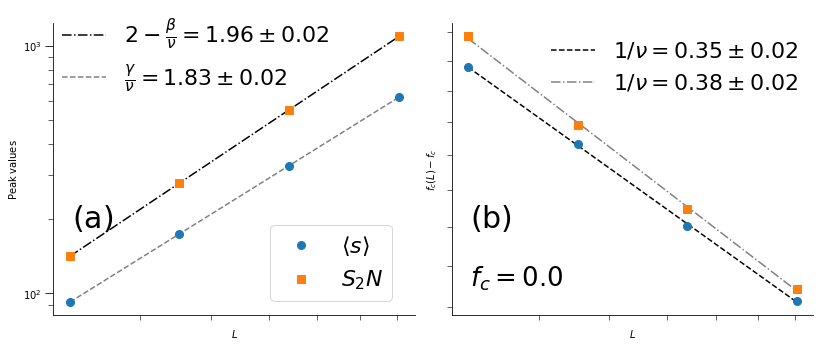

In [27]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = [
    'meanS', 'Nsec', 
    #'varSgcc'
]

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3, 5][:len(measures)]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.0
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2, 4][:len(measures)]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

1024
2048
4096
8192
16384
[0.21484375, 0.18798828125, 0.163818359375, 0.1475830078125]


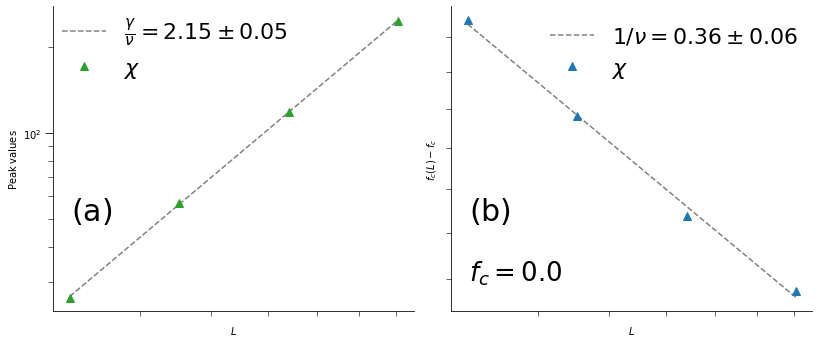

In [28]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = ['varSgcc']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_xlim(56, 340)
    #ax.set_xticks([64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure in ['meanS', 'varSgcc']:
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)


    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=measures_dict[measure]
    )
ax.legend(fontsize=22, loc=(0.0, 0.73), frameon=False)

#########################################################

dfs = {}
for N in sizes:
    print(N)
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
fc = 0.0
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)-f_c$')
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(Y)
    Y = np.array(Y) - fc
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err)
    ax.plot(X, Y_pred, '--', color='grey', label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
ax.legend(fontsize=22, loc=(0.25, 0.73), frameon=False)

#ax.set_ylim(0.07, 0.13)
#ax.set_yticks([0.08, 0.1, 0.12])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.text(0.05, 0.1, r'$f_c={{{}}}$'.format(fc), fontsize=26, transform=ax.transAxes)    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'chi_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

In [29]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'

sizes = np.array([
    256, 512, 1024, 2048, 4096, 8192,# 16384, 
    #32768, 65536, 131072, 262144
])
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_values, nseeds = load_delta(net_type, N, param, attack, min_nseeds=10, return_nseeds=True)
    except FileNotFoundError:
        print(N)
        raise
        
    nseeds_values.append(nseeds)
    
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values, delta_values)

[ 256  512 1024 2048 4096 8192] [0.27649258 0.24228437 0.21210244 0.18683159 0.16535372 0.14727933] [0.20325039 0.20530957 0.20531943 0.2051269  0.20412897 0.20447582]


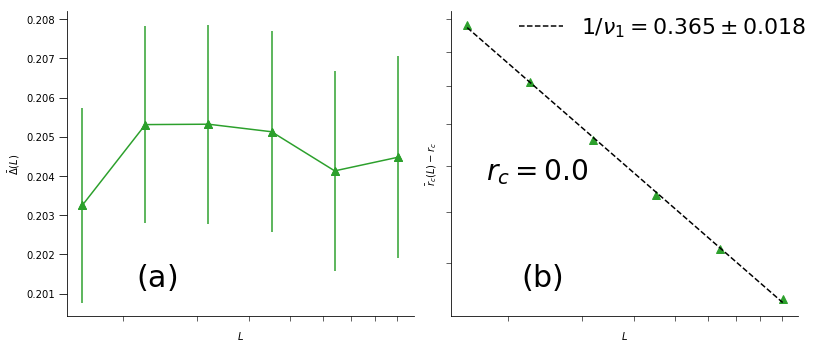

In [30]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
measures = ['meanS', 'Nsec']


ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]
#ax.set_xlim(30, 600)
#ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.2, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.3, 0.5])
#ax.set_yticks([0.39, 0.40, 0.41, 0.42])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\bar{\Delta}(L)$')

X = np.sqrt(sizes)
Y = all_mean_values[:,1]
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)

X = X
Y = Y
Y_err = Y_err

ax.plot(X, Y, '^', color='C2', markersize=8)
ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)

ax = axes[1]
ax.set_yscale('log')
ax.text(0.2, 0.1, letters[1], transform=ax.transAxes, fontsize=30)

## rc = 0
#ax.set_ylim([0.048, 0.12])
#ax.set_yticks([0.05, 0.06, 0.07, 0.08, 0.09, 0.1])
#ax.set_yticks([0.04, 0.06, 0.08, 0.1, 0.12, 0.14])

## rc = 0.04
#ax.set_ylim([0.019, 0.06])
#ax.set_yticks([0.02, 0.03, 0.04, 0.05])

ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$\bar{r}_c(L) - r_c$')
rc = 0.00
X = np.sqrt(sizes)
Y = all_mean_values[:,0] - rc
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.17, 0.88), frameon=False)
#ax.set_xlim(30, 600)
#ax.set_xticks([32, 64, 128, 256, 512])
ax.text(0.1, 0.45, r'$r_c={{{}}}$'.format(rc), fontsize=28, transform=ax.transAxes)
sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

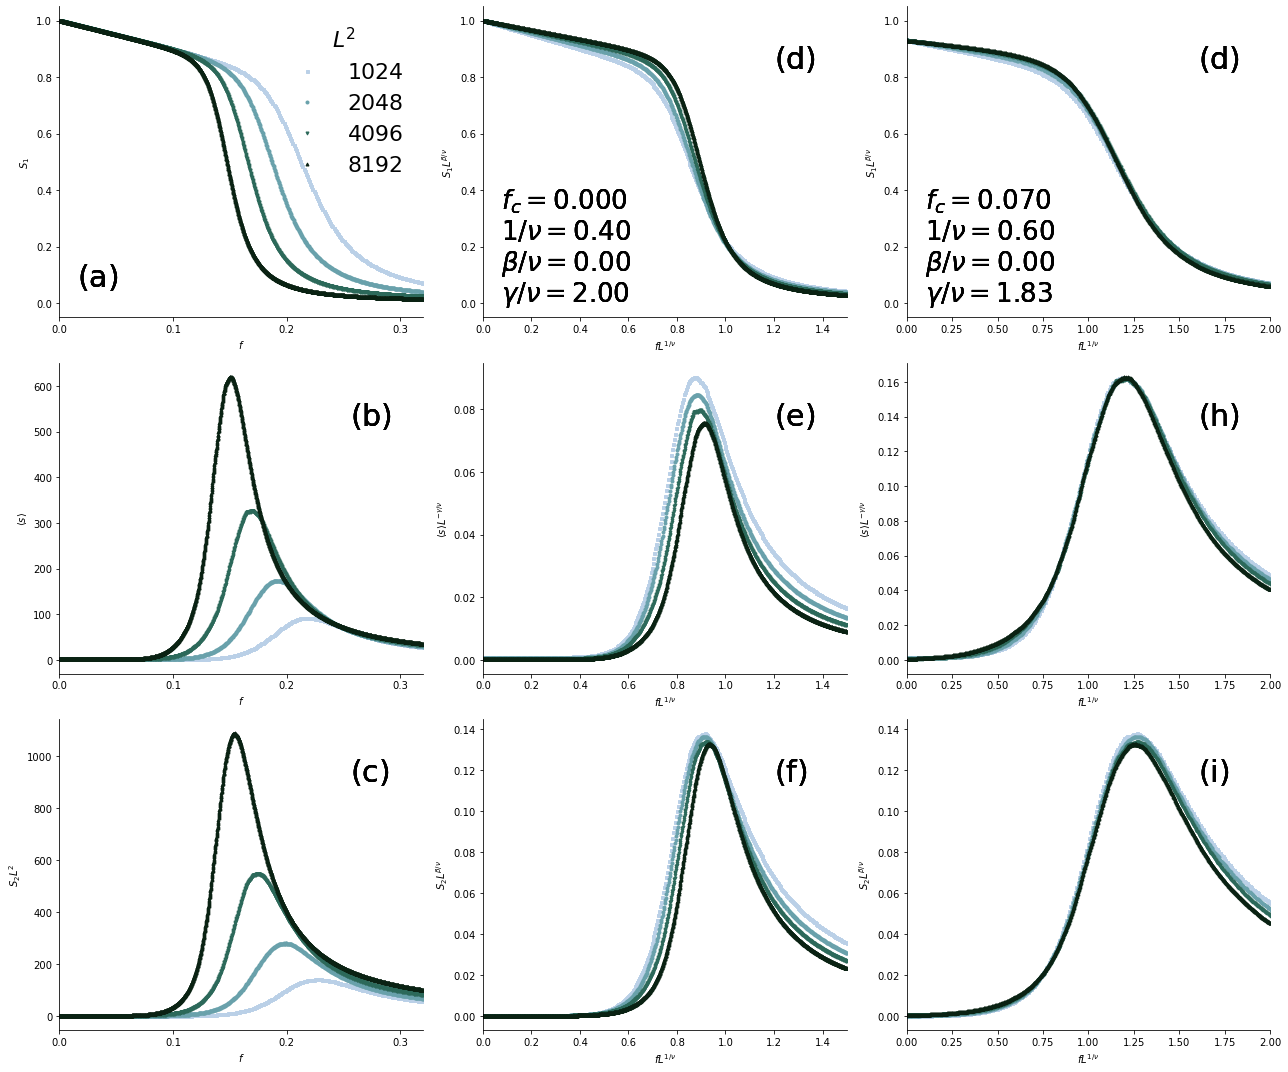

In [31]:
net_type = 'PDT'
param = 'param'
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192]#, 16384, 32768, 65536]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=1000)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 3
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.32)
    ax.set_xticks([0.0, 0.1, 0.2, 0.3])
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(0, 1.5)
    ax.set_xlabel(r'$f L^{1/\nu}$')
for ax in axes[:,2]:
    ax.set_xlim(0, 2)
    ax.set_xlabel(r'$f L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

for i in [1, 2]:
    ax = axes[0,i]
    ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
    ax = axes[1,i]
    ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
    ax = axes[2,i]
    ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')
        
for i, N in enumerate(N_values):
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    
    
for j in [1, 2]:
    if j == 1:
        one_over_nu = 0.4
        gamma_over_nu = 2
        beta_over_nu = 0
        fc = 0.0
    else:
        one_over_nu = 0.6
        gamma_over_nu = 1.83
        beta_over_nu = 0.0
        fc = 0.07
        
    for i, N in enumerate(N_values):
        df = dfs[N]
        L = np.sqrt(N)

        ax = axes[0,j]
        ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)

        ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
        ax.text(
            0.05, 0.35, r'$f_c = {{{:.3f}}}$'.format(fc), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.25, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.15, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26
        )
        ax.text(
            0.05, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26
        )

        ax = axes[1,j]
        ax.text(0.8, 0.8, letters[1+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )  

        ax = axes[2,j]
        ax.text(0.8, 0.8, letters[2+3*j], transform=ax.transAxes, fontsize=30)
        ax.plot(
            (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
            marker=markers[i], markersize=3, color=colormap[i]
        )

legend = axes[0,0].legend(loc='upper right', fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [87]:
attack = 'Btw'

sizes = np.array([
    4096, 8192, 16384, 
    32768, 
    #65536,131072
                 ])
all_mean_values = []
all_std_values = []
nseeds_values = {}
fluctuations = {}
datas = {}
for i, N in enumerate(sizes):
    try:
        delta_data, nseeds = load_delta(net_type, N, param, attack, nseeds=10000, return_nseeds=True)
        nseeds_values[N] = nseeds
        data = delta_data#[:,1]
        #data = data - data.mean()
        datas[N] = data
    except FileNotFoundError:
        print(N)
        raise

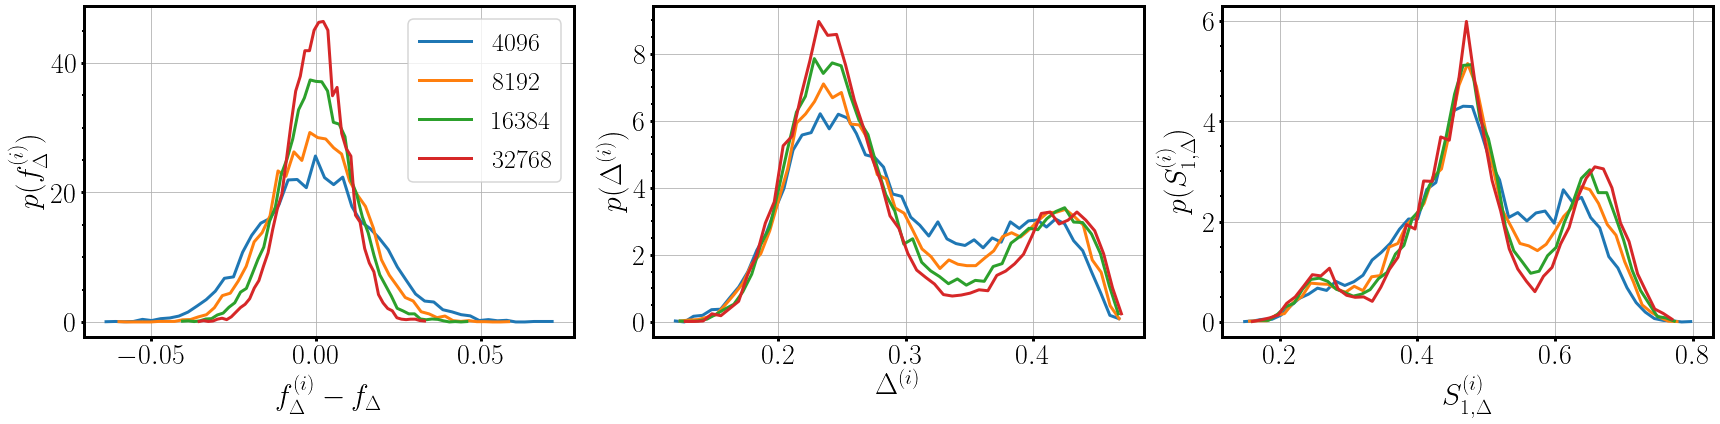

In [88]:
ncols = 3
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax = axes[0]
ax.set_ylabel(r'$p(f_{\Delta}^{(i)})$')
ax.set_xlabel(r'$f_{\Delta}^{(i)}-f_{\Delta}$')

ax = axes[1]
#ax.set_ylim(-10, 700)
#ax.set_xlim(0.1, 0.5)
ax.set_xticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_ylabel(r'$p(\Delta^{(i)})$')
ax.set_xlabel(r'$\Delta^{(i)}$')

ax = axes[2]
#ax.set_xlim(0.2, 1)
#ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
#ax.set_ylim(-10, 700)
ax.set_ylabel(r'$p(S_{1,\Delta}^{(i)})$')
ax.set_xlabel(r'$S_{1,\Delta}^{(i)}$')

for j in range(3):
    ax = axes[j]
    ax.grid(True)
    for N, data in datas.items():
        _data = data[:,j] if j != 0 else data[:,j] - data[:,j].mean()
        #if j == 2:
        #    _data = 1-_data-data[:,0]
        freq, bin_edges = np.histogram(_data, bins=50, density=True)
        bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
        label = r'${{{}}}$'.format(N) if j == 0 else ''
        ax.plot(bin_centers, freq, label=label)
        if j == 0:
            ax.legend()
plt.tight_layout()
plt.show()

# $$S_{1,\Delta}^{(i)} \leq 1-\Delta^{(i)}-f_{\Delta}^{(i)}$$

# $$\Delta^{(i)} \leq 1-S_{1,\Delta}^{(i)}-f_{\Delta}^{(i)}$$

In [69]:
Ngcc_values = [0, 1, 3, 9, 11][::-1]
delta_values = np.abs(np.diff(Ngcc_values))
max_pos = np.argmax(delta_values)
print(Ngcc_values[max_pos+1])
print(delta_values[max_pos])

3
6


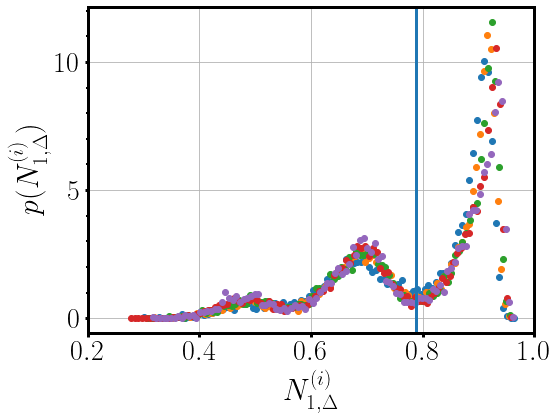

In [78]:
ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax.set_xlim(0.2, 1)
ax.set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel(r'$p(N_{1,\Delta}^{(i)})$')
ax.set_xlabel(r'$N_{1,\Delta}^{(i)}$')
ax.grid(True)
for N, data in datas.items():
    _data = data[:,2]
    freq, bin_edges = np.histogram(_data, bins=100, density=True)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    label = ''
    ax.plot(bin_centers, freq, 'o', label=label)
ax.axvline(_data.mean())
plt.show()

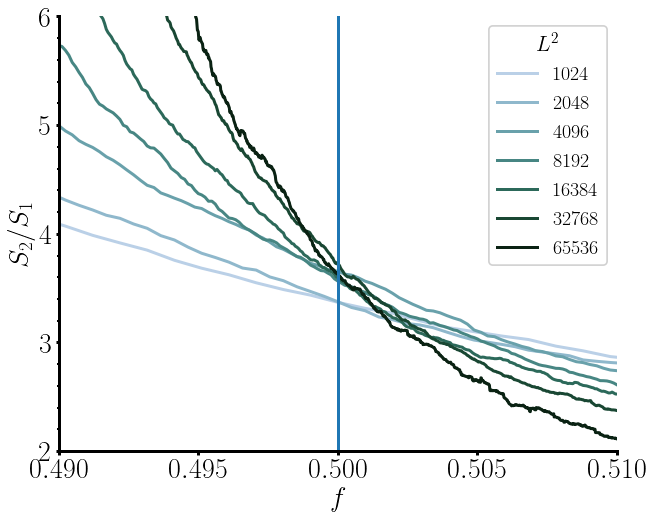

In [31]:
attack = 'Ran'
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536,# 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
binder = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
    
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
    binder[N] = df.meanS_pow4 / df.meanS_pow2**2

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(fmin, fmax)
#ax.set_ylim(ymin, ymax)
ax.set_xlim(0.49, 0.51)
ax.set_ylim(2, 6)
ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]

    label = r'${{{}}}$'.format(N) 
    ax.plot(
        df.f, binder[N], '-',
        color=colors[i], label=label
    )
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.axvline(0.5)
sns.despine()

plt.show()

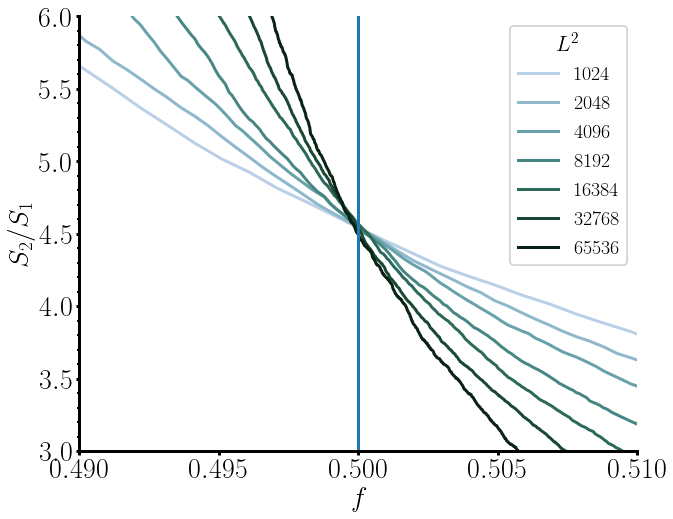

In [40]:
attack = 'Ran'
sizes = [
    1024, 2048, 4096, 8192, 16384, 32768, 65536,# 131072
]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, nseeds=10000)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
binder = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
    
    S2_over_S1[N] = S2/S1
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    #S2_over_S1[N][mask] = np.NaN
    
    binder[N] = df.meanS_pow4 / df.meanS_pow2**2

fmin = 1e-4
fmax = 1e-1
ymin = 2e-6
ymax = 5e-4       

ncols = 1
nrows = 1
fig, ax = plt.subplots(figsize=(10*ncols, 8*nrows), ncols=ncols, nrows=nrows)

#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(fmin, fmax)
#ax.set_ylim(ymin, ymax)
ax.set_xlim(0.49, 0.51)
ax.set_ylim(3, 6)
#ax.set_ylim(0.2, 0.3)
ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)

for i, N in enumerate(N_values):
    L = np.sqrt(N)
    #ax.axvline(1/L**1.3, linestyle=':', color='gray')
    df = dfs[N]

    label = r'${{{}}}$'.format(N) 
    ax.plot(
        df.f, 1/S2_over_S1[N], '-',
        color=colors[i], label=label
    )
        
handles, labels = ax.get_legend_handles_labels()
## Markers
legend1 = ax.legend(handles, labels,
          fontsize=20, loc='best')
legend1.set_title(r'$L^2$', prop={'size':22})
ax.add_artist(legend1)

ax.axvline(0.5)
sns.despine()

plt.show()

<AxesSubplot:xlabel='f'>

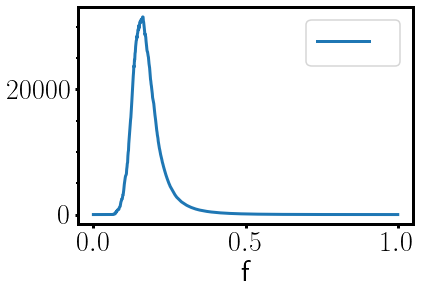

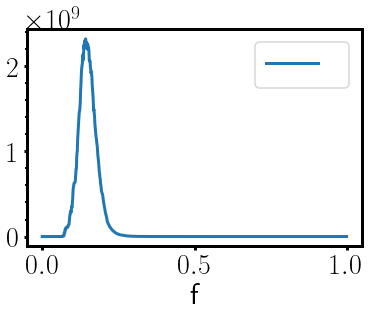

In [8]:
df.plot(x='f', y='meanS_pow2', label='')
df.plot(x='f', y='meanS_pow4', label='')